In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

sns.set(font_scale=2) 
sns.set_style("ticks")
import warnings
warnings.filterwarnings("ignore")

In [68]:
def preprocess_plot(df, cat_name , name,  palette, order, plotting = False):
    ls = ['Cm(pF)', 'Firing_freq_(Hz)_I0','Instant_freq_(Hz)', 'isi_(ms)',  'CaT',  'Ih_at_-120mV', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak','area(mV_ms)', 'rheobase_at_-60mV_(pA)', 'AHP_(mV)', 'Vm',
       'Input_Resistance', 'sPSC_frequency', 'sPSC_Amplitude(pA)','sPSCs_Rise time', 'sPSCs (decay)']

    for column in ls:
        df[column] = pd.to_numeric(df[column])

        if column in ['isi_(ms)', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak','area(mV_ms)', 'AHP_(mV)']:
            param_df = df[df.I_zero != 'silent']
        
        
        else:
            param_df = df
        
        try:
            unique_cat = df[cat_name].unique()
            combos = list(itertools.combinations(unique_cat, 2))

            for combo in combos:
                should_plot = False
                # _, p = stats.ttest_ind(param_df[(param_df[cat_name] == combo[0])][column].dropna(),
                #                         param_df[(param_df[cat_name] == combo[1])][column].dropna(),
                #                     equal_var = False)

                _, p = stats.mannwhitneyu(param_df[(param_df[cat_name] == combo[0])][column].dropna(),
                                        param_df[(param_df[cat_name] == combo[1])][column].dropna())
            
                print(column, combo, p)
               

           
        except ValueError:
            
            continue

        if plotting:
            try:
                print(param_df.groupby(cat_name)[column].mean())
                
                fig,ax = plt.subplots(figsize = (3.5,2.5))
            
                sns.swarmplot(x=cat_name, y =column, data= param_df, palette = palette, order = order, alpha = 0.7, size = 4)
                sns.boxplot(x=cat_name, y =column, data= param_df, palette = palette, order = order, boxprops=dict(alpha=0.5), width = 0.5)
                sns.despine()
                plt.title(column, pad = 20)
                plt.xticks(rotation = 90)
                plt.savefig(f'output_figures/{name}_{column}.png',dpi = 300, bbox_inches = 'tight')
                plt.show()
            except KeyError:
                pass
                

def proportion(df, column1, column2, cols):
    prop = pd.crosstab(df[column1], df[column2], margins = True).reset_index()
    prop = prop.set_index(column1)
    print(prop)
    prop = prop.iloc[:-1, :-1]
    stat, p, dof, expected  = stats.chi2_contingency(prop)
    print(p)
    
    prop = prop.apply(lambda x: x.div(x.sum()).mul(100), axis=1)
    
    
    prop = prop[cols]
    prop = prop.reset_index()
    return prop

def prop_plot(df, column):
    df.plot(x = column, 
              kind = 'bar', 
              stacked = True,  
              mark_right = False,
              color = ['black', 'darkgray','gray'],
              figsize = (3,5), alpha = 0.7)
    plt.xticks(rotation = 0)
    ax = plt.gca()
    plt.ylabel('Percentage (%)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# epnys analysis

In [69]:
ls = ['Cm(pF)', 'Firing_freq_(Hz)_I0','Instant_freq_(Hz)', 'isi_(ms)',  'CaT',  'Ih_at_-120mV', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak','area(mV_ms)', 'rheobase_at_-60mV_(pA)', 'AHP_(mV)', 'Vm',
       'Input_Resistance', 'sPSC_frequency', 'sPSC_Amplitude(pA)','sPSCs_Rise time', 'sPSCs (decay)']

include_gal = True

df = pd.read_csv('ephys_analysis_MC.csv')
df['experiment_day'] = df['experiment_day'].apply(lambda x: str(x).upper()[:13])
df.loc[df.Behaviour_6hFD =='No_FD','Behaviour_6hFD'] = 'Pre'
# df.loc[df.Behaviour_6hFD.isin(['Agg+', 'Agg-']),'Behaviour_6hFD'] = 'Post'
df.rename(columns = {'Instant_freq_(Hz)_1/ISI':'Instant_freq_(Hz)'}, inplace =True)

cat = df.Behaviour_6hFD.unique()

if include_gal:
       gal = df[(df.Gal_positive == 'yes') & (df.Behaviour_6hFD == 'Pre')]
       no_gal = df[(df.Gal_positive == 'no') & (df.Behaviour_6hFD == 'Pre')]
       ephys = pd.concat([df[(df.Gal_positive.isin(['Unknown','no']) & (df.Behaviour_6hFD == 'Pre'))], df[df.Behaviour_6hFD != 'Pre']])
       sample_num= int(no_gal.shape[0]/4)
       ephys = pd.concat([ephys, gal.sample(n = sample_num, random_state = 62)]).reset_index(drop = True)

else:
       ephys = df[df.Gal_positive == 'Unknown']
# ephys.loc[ephys.Behaviour_6hFD.isin(['npy_10', 'npy_100']),'Behaviour_6hFD'] = 'npy'

ephys.to_csv('sampled_ephys_data.csv')

In [70]:
behav = pd.read_csv('ephys_behav.csv')
ephys_behav = pd.merge(ephys, behav, on  = 'ID_mouse')
ephys_behav.columns = [col.replace('(', '_').replace(')', '_') for col in ephys_behav.columns]
ephys_behav.columns = [col.replace(' ', '_').replace('-', '_') for col in ephys_behav.columns]

In [71]:
ephys_behav.columns

Index(['experiment_day', 'sex', 'Gal_positive', 'state', 'estrous_stage',
       'ID_mouse', 'Genotype', 'Behaviour_6hFD', 'Cm_pF_', 'Adaptive',
       'I_zero', 'I_zero_reclassified', '60mV', 'Firing_freq__Hz__I0',
       'Instant_freq__Hz_', 'isi__ms_', 'cat_categ', 'CaT', 'Ih',
       'Ih_at__120mV', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak',
       'area_mV_ms_', 'rheobase_at__60mV__pA_', 'AHP__mV_', 'Vm',
       'Input_Resistance', 'sPSC_frequency', 'sPSC_Amplitude_pA_',
       'sPSCs_Rise_time', 'sPSCs__decay_', 'AC_I0', 'AC__60', 'Comments',
       'estrous_confirmation', 'pup_intro', 'contact', 'attack',
       'contact_latency', 'attack_latency', 'attack_since_contact'],
      dtype='object')

In [72]:
percent_columns = ['Ih_at__120mV', 'CaT', 'Adaptive', 'Firing_freq__Hz__I0'] 
percentages_df = pd.DataFrame(index=ephys_behav['ID_mouse'].unique())

for column in percent_columns:
    percentages = ephys_behav.groupby('ID_mouse')[column].apply(lambda x: (x == 0).sum() / len(x) * 100)
    percentages_df[column + '_percent_nonzero'] = percentages

silent_percentages = ephys_behav.groupby('ID_mouse')['I_zero_reclassified'].apply(lambda x: (x == 'silent').sum() / len(x) * 100).reset_index(name='I_zero_reclassified' + '_percent_silent')
percentages_df = percentages_df.reset_index()
percentages_df.rename(columns={'index': 'ID_mouse'}, inplace=True)
percentages_df = pd.merge(percentages_df, silent_percentages, on='ID_mouse', how='outer')

percentages_df = pd.merge(percentages_df, behav, on = 'ID_mouse')




In [73]:
for y in percentages_df.columns[1:-6]:
    if y != 'attack_since_contact':  # Skip the contact_latency column
        formula = 'attack_since_contact ~ ' + y
        try:
            model = smf.ols(formula, data=percentages_df).fit()
            anova_results = sm.stats.anova_lm(model, typ=2)
            
            if model.pvalues[y] <0.05:
                print(model.pvalues[y], y, model.rsquared)

                sns.lmplot(x = 'attack_since_contact', y = y, data = percentages_df)
           
        except Exception as e:
            continue

0.027972863763820757 sPSC_Amplitude_pA_ 0.2829228101105321


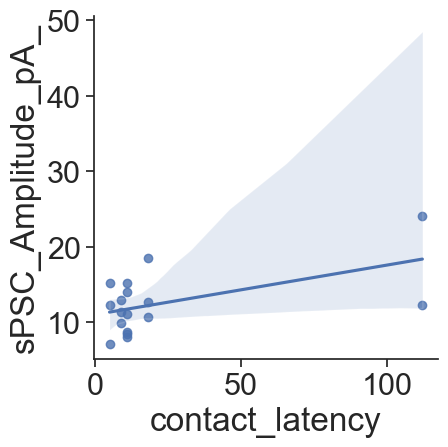

In [74]:
#ephys correlation with behaviour metric
for y in ephys_behav.columns[8:-8]:
    if y != 'contact_latency':  # Skip the contact_latency column
        formula = 'contact_latency ~ ' + y
        try:
            model = smf.ols(formula, data=ephys_behav).fit()
            anova_results = sm.stats.anova_lm(model, typ=2)
            
            if model.pvalues[y] <0.05:
                print(model.pvalues[y], y, model.rsquared)

                sns.lmplot(x = 'contact_latency', y = y, data = ephys_behav)
           
        except Exception as e:
            continue
    

In [75]:
ephys.Behaviour_6hFD.unique()

array(['Pre', 'Agg+', 'Agg-', 'npy_antag', 'npy1r_antag', 'npy2r_antag',
       'npy_10_paired', 'npy_10', 'npy_100_paired', 'npy_100',
       'agrp_100_paired', 'agrp_100', 'ZD7288', 'ZD7288_20'], dtype=object)

## all properties

Cm(pF) ('Pre', 'Agg+') 0.2112995473337107
Firing_freq_(Hz)_I0 ('Pre', 'Agg+') 0.010819464803954192
Firing_freq_(Hz)_I0 ('Pre', 'Agg-') 0.050500440681557957
Firing_freq_(Hz)_I0 ('Pre', 'npy1r_antag') 0.2573383694997692
Firing_freq_(Hz)_I0 ('Pre', 'npy2r_antag') 0.3350979644209905
Firing_freq_(Hz)_I0 ('Pre', 'npy_10') 0.7522137312931874
Firing_freq_(Hz)_I0 ('Pre', 'ZD7288') 0.00160254915119926
Firing_freq_(Hz)_I0 ('Agg+', 'Agg-') 0.000409831745363416
Firing_freq_(Hz)_I0 ('Agg+', 'npy1r_antag') 0.01378110226214151
Firing_freq_(Hz)_I0 ('Agg+', 'npy2r_antag') 0.9498704530360561
Firing_freq_(Hz)_I0 ('Agg+', 'npy_10') 0.023627602742951646
Firing_freq_(Hz)_I0 ('Agg+', 'ZD7288') 0.08873673305386351
Firing_freq_(Hz)_I0 ('Agg-', 'npy1r_antag') 0.7211105212310518
Firing_freq_(Hz)_I0 ('Agg-', 'npy2r_antag') 0.16477764003475115
Firing_freq_(Hz)_I0 ('Agg-', 'npy_10') 0.042326107855526485
Firing_freq_(Hz)_I0 ('Agg-', 'ZD7288') 0.0007718608499895493
Firing_freq_(Hz)_I0 ('npy1r_antag', 'npy2r_antag') 0.

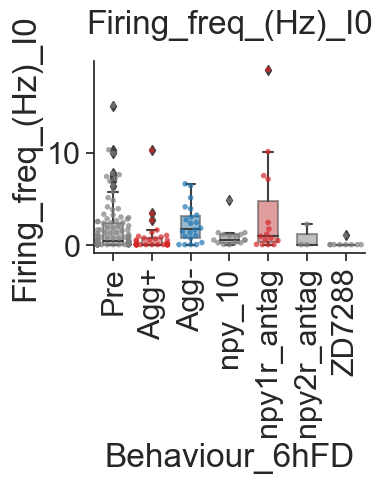

Instant_freq_(Hz) ('Pre', 'Agg+') 0.007126302284415039
Instant_freq_(Hz) ('Pre', 'Agg-') 0.13791987695468466
Instant_freq_(Hz) ('Pre', 'npy1r_antag') 0.3387879475549421
Instant_freq_(Hz) ('Pre', 'npy2r_antag') 0.3257348694282074
Instant_freq_(Hz) ('Pre', 'npy_10') 0.8074135310571166
Instant_freq_(Hz) ('Pre', 'ZD7288') 0.002066214299640664
Instant_freq_(Hz) ('Agg+', 'Agg-') 0.0010172795558072499
Instant_freq_(Hz) ('Agg+', 'npy1r_antag') 0.011311535506048284
Instant_freq_(Hz) ('Agg+', 'npy2r_antag') 0.8999076646294859
Instant_freq_(Hz) ('Agg+', 'npy_10') 0.02033905481943857
Instant_freq_(Hz) ('Agg+', 'ZD7288') 0.09900021305885116
Instant_freq_(Hz) ('Agg-', 'npy1r_antag') 0.9381289063266207
Instant_freq_(Hz) ('Agg-', 'npy2r_antag') 0.22207326403075167
Instant_freq_(Hz) ('Agg-', 'npy_10') 0.15400697682926207
Instant_freq_(Hz) ('Agg-', 'ZD7288') 0.0018326276980825283
Instant_freq_(Hz) ('npy1r_antag', 'npy2r_antag') 0.28129951455993896
Instant_freq_(Hz) ('npy1r_antag', 'npy_10') 0.6326817255

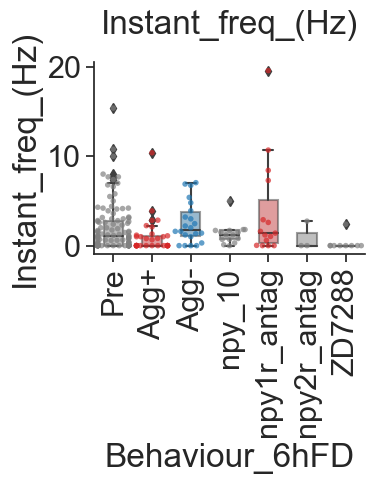

isi_(ms) ('Pre', 'Agg+') 0.8015286410640747
isi_(ms) ('Pre', 'Agg-') 0.054024744647440136
isi_(ms) ('Pre', 'npy1r_antag') 0.292912278038327
isi_(ms) ('Pre', 'npy2r_antag') 0.7012987012987014
isi_(ms) ('Pre', 'npy_10') 0.19083431548398933
isi_(ms) ('Pre', 'ZD7288') 0.9610389610389612
isi_(ms) ('Agg+', 'Agg-') 0.014668259625073753
isi_(ms) ('Agg+', 'npy1r_antag') 0.31716652052312344
isi_(ms) ('Agg+', 'npy2r_antag') 0.5
isi_(ms) ('Agg+', 'npy_10') 0.4711785048105669
isi_(ms) ('Agg+', 'ZD7288') 0.75
isi_(ms) ('Agg-', 'npy1r_antag') 0.6566808075579458
isi_(ms) ('Agg-', 'npy2r_antag') 1.0
isi_(ms) ('Agg-', 'npy_10') 0.0013210768466118527
isi_(ms) ('Agg-', 'ZD7288') 0.42105263157894735
isi_(ms) ('npy1r_antag', 'npy2r_antag') 0.9230769230769231
isi_(ms) ('npy1r_antag', 'npy_10') 0.08461244945949703
isi_(ms) ('npy1r_antag', 'ZD7288') 0.9230769230769231
isi_(ms) ('npy2r_antag', 'npy_10') 0.20099425588307962
isi_(ms) ('npy2r_antag', 'ZD7288') 1.0
isi_(ms) ('npy_10', 'ZD7288') 0.7272823220714764
B

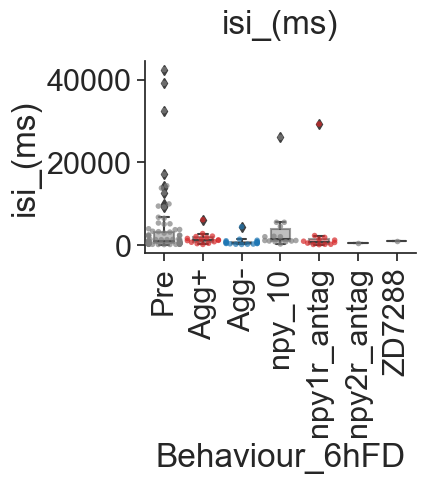

CaT ('Pre', 'Agg+') 0.49563408102644235
CaT ('Pre', 'Agg-') 0.3954543611558381
CaT ('Pre', 'npy1r_antag') 0.5461647859931317
CaT ('Pre', 'npy2r_antag') 0.4778774882001815
CaT ('Pre', 'npy_10') 0.04651313339583601
CaT ('Pre', 'ZD7288') 0.726065942091648
CaT ('Agg+', 'Agg-') 0.1718067166849695
CaT ('Agg+', 'npy1r_antag') 0.9086094786774864
CaT ('Agg+', 'npy2r_antag') 0.577024759818451
CaT ('Agg+', 'npy_10') 0.18520400662349512
CaT ('Agg+', 'ZD7288') 0.8865276989284464
CaT ('Agg-', 'npy1r_antag') 0.16745288464179808
CaT ('Agg-', 'npy2r_antag') 0.3798023795593065
CaT ('Agg-', 'npy_10') 0.00958590195616561
CaT ('Agg-', 'ZD7288') 0.4969394928289175
CaT ('npy1r_antag', 'npy2r_antag') 0.5331682451821596
CaT ('npy1r_antag', 'npy_10') 0.14285200738798648
CaT ('npy1r_antag', 'ZD7288') 0.7839136702502763
CaT ('npy2r_antag', 'npy_10') 0.8504362683123465
CaT ('npy2r_antag', 'ZD7288') 0.6683941835413165
CaT ('npy_10', 'ZD7288') 0.1791391868079415
Behaviour_6hFD
Agg+           4.605000
Agg-           

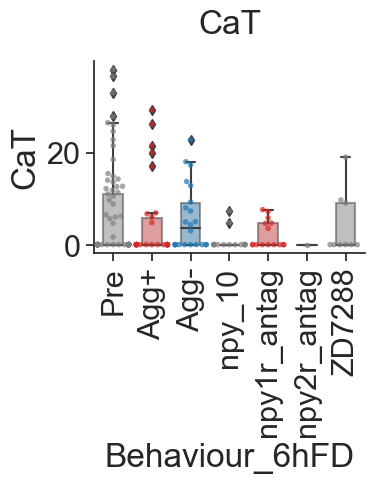

Ih_at_-120mV ('Pre', 'Agg+') 0.016953540388972527
Ih_at_-120mV ('Pre', 'Agg-') 0.5161858338475181
Ih_at_-120mV ('Pre', 'npy1r_antag') 0.895539682433509
Ih_at_-120mV ('Pre', 'npy2r_antag') 0.8824332961615742
Ih_at_-120mV ('Pre', 'npy_10') 0.04298660120520486
Ih_at_-120mV ('Pre', 'ZD7288') 0.00038696578446780085
Ih_at_-120mV ('Agg+', 'Agg-') 0.0012473463277721786
Ih_at_-120mV ('Agg+', 'npy1r_antag') 0.14420227060743224
Ih_at_-120mV ('Agg+', 'npy2r_antag') 0.3166561539626107
Ih_at_-120mV ('Agg+', 'npy_10') 0.7891993382904234
Ih_at_-120mV ('Agg+', 'ZD7288') 0.0029161894382185396
Ih_at_-120mV ('Agg-', 'npy1r_antag') 0.5054880344356945
Ih_at_-120mV ('Agg-', 'npy2r_antag') 0.5463944638265984
Ih_at_-120mV ('Agg-', 'npy_10') 0.009854341957769078
Ih_at_-120mV ('Agg-', 'ZD7288') 3.1739315352409464e-05
Ih_at_-120mV ('npy1r_antag', 'npy2r_antag') 1.0
Ih_at_-120mV ('npy1r_antag', 'npy_10') 0.105925447265867
Ih_at_-120mV ('npy1r_antag', 'ZD7288') 0.0014493157754198454
Ih_at_-120mV ('npy2r_antag', 'np

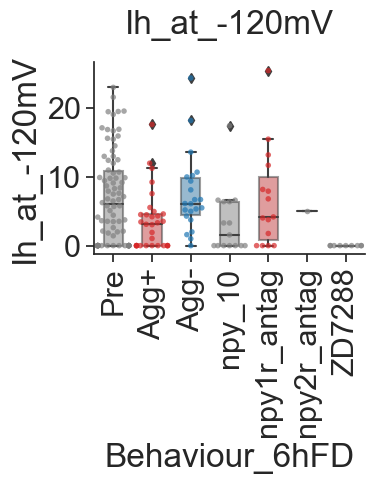

AP_ampl ('Pre', 'Agg+') 0.3025141906911134
AP_ampl ('Pre', 'Agg-') 0.6484995979902848
AP_ampl ('Pre', 'npy1r_antag') 0.0019617391708031686
AP_ampl ('Pre', 'npy2r_antag') 0.5762846637858869
AP_ampl ('Pre', 'npy_10') 0.004388294648604545
AP_ampl ('Pre', 'ZD7288') 0.6150079488107387
AP_ampl ('Agg+', 'Agg-') 0.7585816773946292
AP_ampl ('Agg+', 'npy1r_antag') 0.033761671550520726
AP_ampl ('Agg+', 'npy2r_antag') 1.0
AP_ampl ('Agg+', 'npy_10') 0.2132192152945539
AP_ampl ('Agg+', 'ZD7288') 1.0
AP_ampl ('Agg-', 'npy1r_antag') 0.006323780925748658
AP_ampl ('Agg-', 'npy2r_antag') 0.7368421052631579
AP_ampl ('Agg-', 'npy_10') 0.03492409844090982
AP_ampl ('Agg-', 'ZD7288') 0.8421052631578947
AP_ampl ('npy1r_antag', 'npy2r_antag') 0.46153846153846156
AP_ampl ('npy1r_antag', 'npy_10') 0.26838600797372236
AP_ampl ('npy1r_antag', 'ZD7288') 0.3076923076923077
AP_ampl ('npy2r_antag', 'npy_10') 0.9074562823909351
AP_ampl ('npy2r_antag', 'ZD7288') 1.0
AP_ampl ('npy_10', 'ZD7288') 0.2954554327459259
Behavio

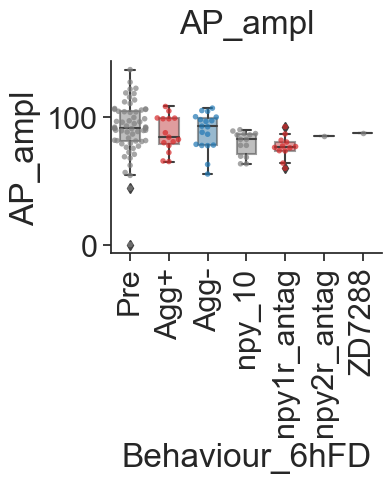

AP_halfwidth ('Pre', 'Agg+') 0.46219593535882597
AP_halfwidth ('Pre', 'Agg-') 0.04959538934130666
AP_halfwidth ('Pre', 'npy1r_antag') 0.8858255259367204
AP_halfwidth ('Pre', 'npy2r_antag') 0.39409577434535703
AP_halfwidth ('Pre', 'npy_10') 0.4113404558415319
AP_halfwidth ('Pre', 'ZD7288') 0.7332069215467361
AP_halfwidth ('Agg+', 'Agg-') 0.04087328572937924
AP_halfwidth ('Agg+', 'npy1r_antag') 0.7142261743773299
AP_halfwidth ('Agg+', 'npy2r_antag') 0.625
AP_halfwidth ('Agg+', 'npy_10') 0.2650982114145718
AP_halfwidth ('Agg+', 'ZD7288') 0.875
AP_halfwidth ('Agg-', 'npy1r_antag') 0.18847057213355278
AP_halfwidth ('Agg-', 'npy2r_antag') 0.521902434503253
AP_halfwidth ('Agg-', 'npy_10') 0.2014722447820252
AP_halfwidth ('Agg-', 'ZD7288') 0.6473550172983791
AP_halfwidth ('npy1r_antag', 'npy2r_antag') 0.3482470798764127
AP_halfwidth ('npy1r_antag', 'npy_10') 0.6795833053412014
AP_halfwidth ('npy1r_antag', 'ZD7288') 0.8929613676482037
AP_halfwidth ('npy2r_antag', 'npy_10') 0.19977456142037298
A

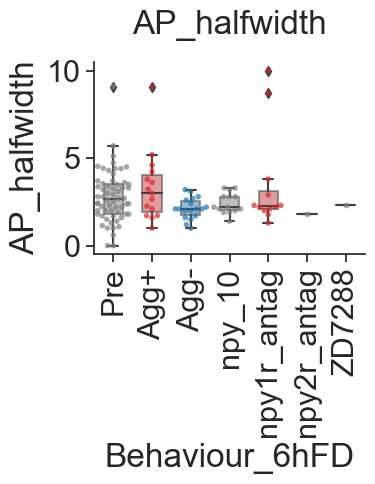

AP_time_to_peak ('Pre', 'Agg+') 0.43721735287798613
AP_time_to_peak ('Pre', 'Agg-') 0.8469049089292453
AP_time_to_peak ('Pre', 'npy1r_antag') 0.03377040596934124
AP_time_to_peak ('Pre', 'npy2r_antag') 0.9109401694038496
AP_time_to_peak ('Pre', 'npy_10') 0.2762024722179164
AP_time_to_peak ('Pre', 'ZD7288') 0.48448574129036415
AP_time_to_peak ('Agg+', 'Agg-') 0.46913433639048585
AP_time_to_peak ('Agg+', 'npy1r_antag') 0.09169581650975384
AP_time_to_peak ('Agg+', 'npy2r_antag') 0.8281380965973053
AP_time_to_peak ('Agg+', 'npy_10') 0.2380676377215949
AP_time_to_peak ('Agg+', 'ZD7288') 1.0
AP_time_to_peak ('Agg-', 'npy1r_antag') 0.004385123090463345
AP_time_to_peak ('Agg-', 'npy2r_antag') 1.0
AP_time_to_peak ('Agg-', 'npy_10') 0.19494980473081336
AP_time_to_peak ('Agg-', 'ZD7288') 0.40904435007858275
AP_time_to_peak ('npy1r_antag', 'npy2r_antag') 0.27698616050758385
AP_time_to_peak ('npy1r_antag', 'npy_10') 0.17880645180850752
AP_time_to_peak ('npy1r_antag', 'ZD7288') 0.1355252044083561
AP_

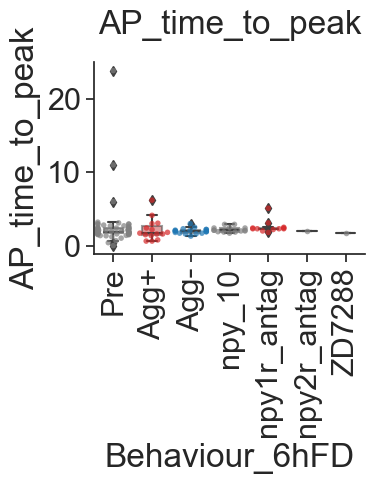

area(mV_ms) ('Pre', 'Agg+') 0.7991136298069239
area(mV_ms) ('Pre', 'Agg-') 0.016837642364698622
area(mV_ms) ('Pre', 'npy1r_antag') 0.2426447163920502
area(mV_ms) ('Pre', 'npy2r_antag') 0.2637329190114216
area(mV_ms) ('Pre', 'npy_10') 0.06639667441265373
area(mV_ms) ('Pre', 'ZD7288') 0.538761861912151
area(mV_ms) ('Agg+', 'Agg-') 0.3027726388020737
area(mV_ms) ('Agg+', 'npy1r_antag') 0.6083530708674068
area(mV_ms) ('Agg+', 'npy2r_antag') 0.3851969751355837
area(mV_ms) ('Agg+', 'npy_10') 0.47112381425774463
area(mV_ms) ('Agg+', 'ZD7288') 1.0
area(mV_ms) ('Agg-', 'npy1r_antag') 0.9831126875838702
area(mV_ms) ('Agg-', 'npy2r_antag') 0.5263157894736842
area(mV_ms) ('Agg-', 'npy_10') 0.5814871781655195
area(mV_ms) ('Agg-', 'ZD7288') 1.0
area(mV_ms) ('npy1r_antag', 'npy2r_antag') 0.46153846153846156
area(mV_ms) ('npy1r_antag', 'npy_10') 0.8975980671010817
area(mV_ms) ('npy1r_antag', 'ZD7288') 0.9230769230769231
area(mV_ms) ('npy2r_antag', 'npy_10') 0.4157976549629324
area(mV_ms) ('npy2r_antag

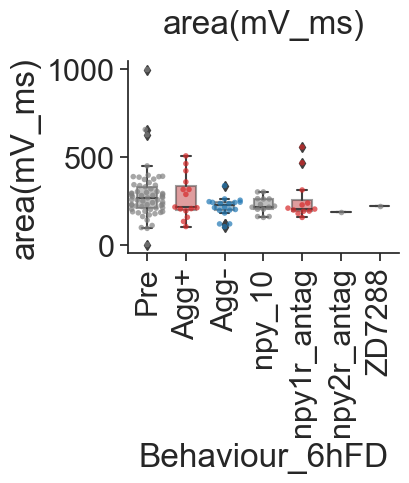

rheobase_at_-60mV_(pA) ('Pre', 'Agg+') 0.11034275446826022
rheobase_at_-60mV_(pA) ('Pre', 'Agg-') 0.14643851650205936
rheobase_at_-60mV_(pA) ('Pre', 'npy1r_antag') 0.21018602260282315
rheobase_at_-60mV_(pA) ('Pre', 'npy2r_antag') 0.3135779374339708
rheobase_at_-60mV_(pA) ('Pre', 'npy_10') 0.3075583468392078
rheobase_at_-60mV_(pA) ('Pre', 'ZD7288') 0.03158113135357213
rheobase_at_-60mV_(pA) ('Agg+', 'Agg-') 0.8517483123001515
rheobase_at_-60mV_(pA) ('Agg+', 'npy1r_antag') 0.8826170792299943
rheobase_at_-60mV_(pA) ('Agg+', 'npy2r_antag') 0.7854365954435134
rheobase_at_-60mV_(pA) ('Agg+', 'npy_10') 0.32297044507062334
rheobase_at_-60mV_(pA) ('Agg+', 'ZD7288') 0.006959104791979626
rheobase_at_-60mV_(pA) ('Agg-', 'npy1r_antag') 1.0
rheobase_at_-60mV_(pA) ('Agg-', 'npy2r_antag') 0.527206586614108
rheobase_at_-60mV_(pA) ('Agg-', 'npy_10') 0.722675841016618
rheobase_at_-60mV_(pA) ('Agg-', 'ZD7288') 0.01342158738742916
rheobase_at_-60mV_(pA) ('npy1r_antag', 'npy2r_antag') 0.562134736409149
rheo

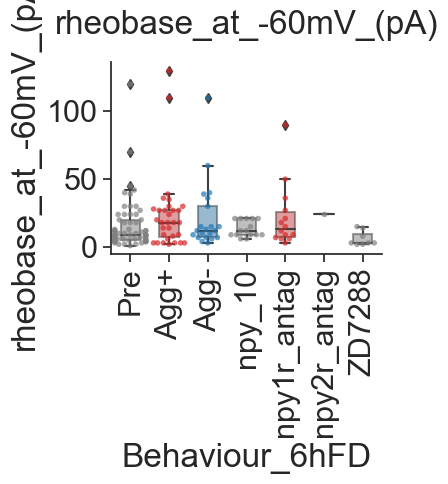

AHP_(mV) ('Pre', 'Agg+') 0.43839162689464706
AHP_(mV) ('Pre', 'Agg-') 0.682407498428275
AHP_(mV) ('Pre', 'npy1r_antag') 0.1042686796936504
AHP_(mV) ('Pre', 'npy2r_antag') 0.5894634785664055
AHP_(mV) ('Pre', 'npy_10') 0.9339974866580283
AHP_(mV) ('Pre', 'ZD7288') 0.9547027682916275
AHP_(mV) ('Agg+', 'Agg-') 0.5751721848393921
AHP_(mV) ('Agg+', 'npy1r_antag') 0.23182923128832922
AHP_(mV) ('Agg+', 'npy2r_antag') 0.5148719362740404
AHP_(mV) ('Agg+', 'npy_10') 0.4190312130238445
AHP_(mV) ('Agg+', 'ZD7288') 0.5148719362740404
AHP_(mV) ('Agg-', 'npy1r_antag') 0.13279539648494482
AHP_(mV) ('Agg-', 'npy2r_antag') 0.7368421052631579
AHP_(mV) ('Agg-', 'npy_10') 0.9242786302330765
AHP_(mV) ('Agg-', 'ZD7288') 0.8421052631578947
AHP_(mV) ('npy1r_antag', 'npy2r_antag') 0.9230769230769231
AHP_(mV) ('npy1r_antag', 'npy_10') 0.1892079668742509
AHP_(mV) ('npy1r_antag', 'ZD7288') 0.46153846153846156
AHP_(mV) ('npy2r_antag', 'npy_10') 0.560726639179391
AHP_(mV) ('npy2r_antag', 'ZD7288') 1.0
AHP_(mV) ('npy_

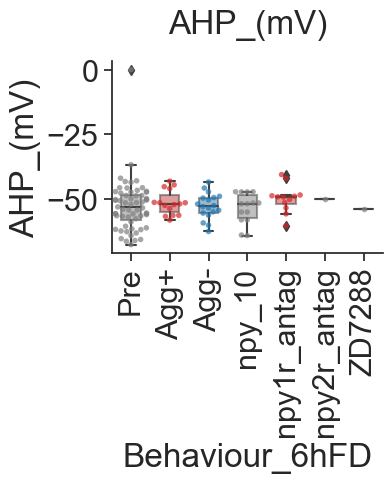

Vm ('Pre', 'Agg+') 0.7001860857748857
Vm ('Pre', 'Agg-') 0.5059726708502595
Vm ('Pre', 'npy1r_antag') 0.06155381242762307
Vm ('Pre', 'npy2r_antag') 0.1142857142857143
Vm ('Pre', 'npy_10') 0.44928219290153704
Vm ('Pre', 'ZD7288') 0.05696856621362753
Vm ('Agg+', 'Agg-') 0.911084019139028
Vm ('Agg+', 'npy1r_antag') 0.26607738079943555
Vm ('Agg+', 'npy2r_antag') 0.29411764705882354
Vm ('Agg+', 'npy_10') 0.7895075436379628
Vm ('Agg+', 'ZD7288') 0.16777100640194242
Vm ('Agg-', 'npy1r_antag') 0.15927452165285128
Vm ('Agg-', 'npy2r_antag') 0.17391304347826086
Vm ('Agg-', 'npy_10') 0.816478309328865
Vm ('Agg-', 'ZD7288') 0.1572500789959627
Vm ('npy1r_antag', 'npy2r_antag') 0.375
Vm ('npy1r_antag', 'npy_10') 0.2805743286200132
Vm ('npy1r_antag', 'ZD7288') 0.8580276569875211
Vm ('npy2r_antag', 'npy_10') 0.27630291733748347
Vm ('npy2r_antag', 'ZD7288') 0.6000000000000001
Vm ('npy_10', 'ZD7288') 0.16976845909636884
Behaviour_6hFD
Agg+          -46.459550
Agg-          -45.997810
Pre           -46.7

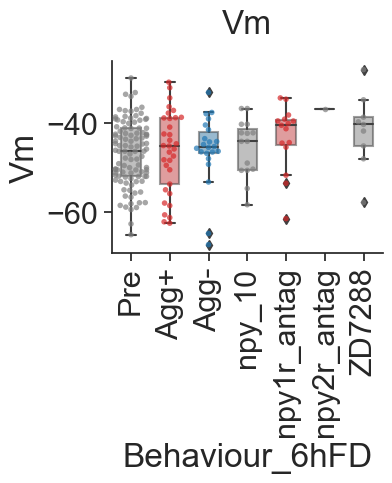

Input_Resistance ('Pre', 'Agg+') 0.00959484260193699
Input_Resistance ('Pre', 'Agg-') 0.7897476721570257
Input_Resistance ('Pre', 'npy1r_antag') 0.20332306298223934
Input_Resistance ('Pre', 'npy2r_antag') 0.9879518072289152
Input_Resistance ('Pre', 'npy_10') 0.0018205584225745807
Input_Resistance ('Pre', 'ZD7288') 0.0012071520714673186
Input_Resistance ('Agg+', 'Agg-') 0.04608250364957072
Input_Resistance ('Agg+', 'npy1r_antag') 0.4121413951366578
Input_Resistance ('Agg+', 'npy2r_antag') 0.5625
Input_Resistance ('Agg+', 'npy_10') 0.3249635822878799
Input_Resistance ('Agg+', 'ZD7288') 0.10535123506497364
Input_Resistance ('Agg-', 'npy1r_antag') 0.24603234909826666
Input_Resistance ('Agg-', 'npy2r_antag') 1.0
Input_Resistance ('Agg-', 'npy_10') 0.005615090963281534
Input_Resistance ('Agg-', 'ZD7288') 0.0021541104518153133
Input_Resistance ('npy1r_antag', 'npy2r_antag') 0.75
Input_Resistance ('npy1r_antag', 'npy_10') 0.08132513384236902
Input_Resistance ('npy1r_antag', 'ZD7288') 0.0426247

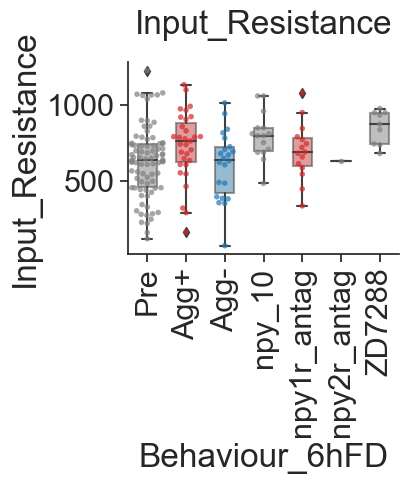

sPSC_frequency ('Pre', 'Agg+') 0.6299516553223251
sPSC_frequency ('Pre', 'Agg-') 0.16569340327720272
sPSC_frequency ('Pre', 'npy1r_antag') 0.007897739636139703
sPSC_frequency ('Pre', 'npy2r_antag') 0.01842812497497992
sPSC_frequency ('Pre', 'npy_10') 0.0860132039524211
sPSC_frequency ('Pre', 'ZD7288') 0.00012029387794381674
sPSC_frequency ('Agg+', 'Agg-') 0.4758363925692679
sPSC_frequency ('Agg+', 'npy1r_antag') 0.004334839305559387
sPSC_frequency ('Agg+', 'npy2r_antag') 0.030499499832943366
sPSC_frequency ('Agg+', 'npy_10') 0.07085963754292053
sPSC_frequency ('Agg+', 'ZD7288') 0.0014364535876886526
sPSC_frequency ('Agg-', 'npy1r_antag') 0.0015203172563771129
sPSC_frequency ('Agg-', 'npy2r_antag') 0.0014864362690449645
sPSC_frequency ('Agg-', 'npy_10') 0.024980650054050743
sPSC_frequency ('Agg-', 'ZD7288') 0.0016887282854299345
sPSC_frequency ('npy1r_antag', 'npy2r_antag') 1.0
sPSC_frequency ('npy1r_antag', 'npy_10') 0.5116963243361916
sPSC_frequency ('npy1r_antag', 'ZD7288') 2.8553131

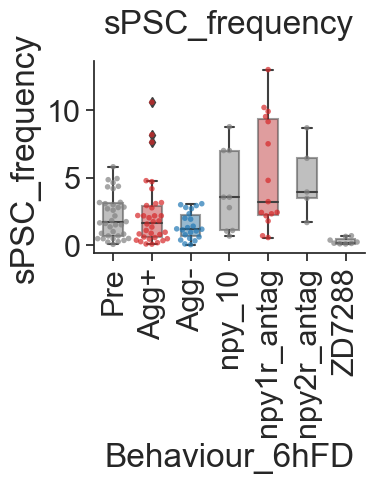

sPSC_Amplitude(pA) ('Pre', 'Agg+') 0.5687163130626809
sPSC_Amplitude(pA) ('Pre', 'Agg-') 0.025875307502539382
sPSC_Amplitude(pA) ('Pre', 'npy1r_antag') 0.5216038164206143
sPSC_Amplitude(pA) ('Pre', 'npy2r_antag') 0.03304107166663274
sPSC_Amplitude(pA) ('Pre', 'npy_10') 0.8314555344756641
sPSC_Amplitude(pA) ('Pre', 'ZD7288') 0.002009908114278183
sPSC_Amplitude(pA) ('Agg+', 'Agg-') 0.059016462042317176
sPSC_Amplitude(pA) ('Agg+', 'npy1r_antag') 0.7203917662706332
sPSC_Amplitude(pA) ('Agg+', 'npy2r_antag') 0.030696978065399116
sPSC_Amplitude(pA) ('Agg+', 'npy_10') 0.8931110395377335
sPSC_Amplitude(pA) ('Agg+', 'ZD7288') 0.003379108413355577
sPSC_Amplitude(pA) ('Agg-', 'npy1r_antag') 0.7451488435418439
sPSC_Amplitude(pA) ('Agg-', 'npy2r_antag') 0.013508667801049576
sPSC_Amplitude(pA) ('Agg-', 'npy_10') 0.38336803110736906
sPSC_Amplitude(pA) ('Agg-', 'ZD7288') 0.013642787090909672
sPSC_Amplitude(pA) ('npy1r_antag', 'npy2r_antag') 0.08861677464641793
sPSC_Amplitude(pA) ('npy1r_antag', 'npy_1

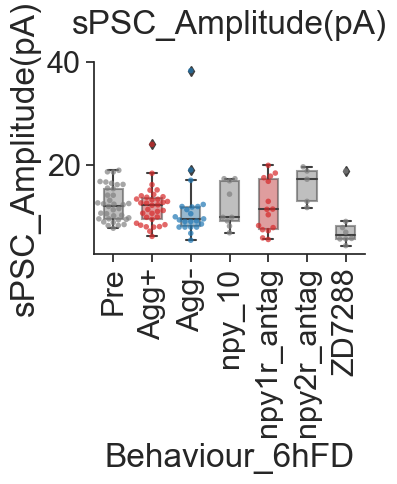

sPSCs_Rise time ('Pre', 'Agg+') 0.5523105533089088
sPSCs_Rise time ('Pre', 'Agg-') 0.3970241676687203
sPSCs_Rise time ('Pre', 'npy1r_antag') 0.9820976399517795
sPSCs_Rise time ('Pre', 'npy2r_antag') 0.032383519707804696
sPSCs_Rise time ('Pre', 'npy_10') 0.6762317557648871
sPSCs_Rise time ('Pre', 'ZD7288') 0.5400376799085684
sPSCs_Rise time ('Agg+', 'Agg-') 0.24122416689162263
sPSCs_Rise time ('Agg+', 'npy1r_antag') 0.7596540919314303
sPSCs_Rise time ('Agg+', 'npy2r_antag') 0.020973464679519976
sPSCs_Rise time ('Agg+', 'npy_10') 1.0
sPSCs_Rise time ('Agg+', 'ZD7288') 0.7597296065659777
sPSCs_Rise time ('Agg-', 'npy1r_antag') 0.29648351958617036
sPSCs_Rise time ('Agg-', 'npy2r_antag') 0.429995669997035
sPSCs_Rise time ('Agg-', 'npy_10') 0.45717191551165437
sPSCs_Rise time ('Agg-', 'ZD7288') 0.620780270779305
sPSCs_Rise time ('npy1r_antag', 'npy2r_antag') 0.06610795467309512
sPSCs_Rise time ('npy1r_antag', 'npy_10') 0.5867487130549034
sPSCs_Rise time ('npy1r_antag', 'ZD7288') 0.8966679097

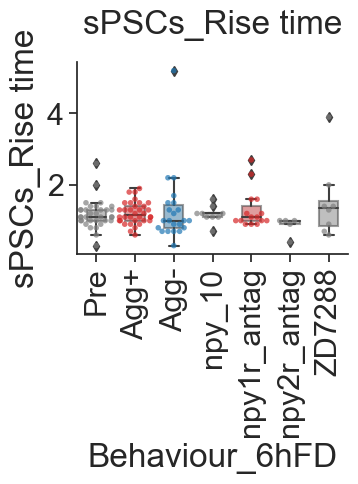

sPSCs (decay) ('Pre', 'Agg+') 0.445197370104469
sPSCs (decay) ('Pre', 'Agg-') 0.5852881642217079
sPSCs (decay) ('Pre', 'npy1r_antag') 0.18937115235964863
sPSCs (decay) ('Pre', 'npy2r_antag') 0.5485996030001785
sPSCs (decay) ('Pre', 'npy_10') 0.08583563248185513
sPSCs (decay) ('Pre', 'ZD7288') 0.33514868886616145
sPSCs (decay) ('Agg+', 'Agg-') 0.9861774126895494
sPSCs (decay) ('Agg+', 'npy1r_antag') 0.43482039170687026
sPSCs (decay) ('Agg+', 'npy2r_antag') 0.35552846079161865
sPSCs (decay) ('Agg+', 'npy_10') 0.3171835069285409
sPSCs (decay) ('Agg+', 'ZD7288') 0.3042033696719191
sPSCs (decay) ('Agg-', 'npy1r_antag') 0.2752236364320767
sPSCs (decay) ('Agg-', 'npy2r_antag') 0.3452441476678495
sPSCs (decay) ('Agg-', 'npy_10') 0.17422681833334774
sPSCs (decay) ('Agg-', 'ZD7288') 0.3536940897929446
sPSCs (decay) ('npy1r_antag', 'npy2r_antag') 0.23000515995872037
sPSCs (decay) ('npy1r_antag', 'npy_10') 0.59134374002816
sPSCs (decay) ('npy1r_antag', 'ZD7288') 0.23820245801669948
sPSCs (decay) (

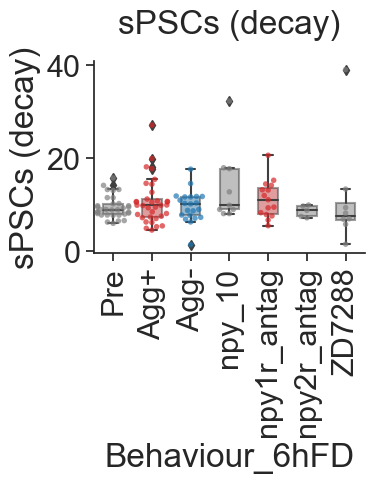

In [76]:
filter_cat = ['Pre', 'Agg+', 'Agg-', 'npy_10', 'npy1r_antag', 'npy2r_antag', 'ZD7288']


preprocess_plot(ephys[ephys.Behaviour_6hFD.isin(filter_cat)],'Behaviour_6hFD', 'pan', 
                palette=['Gray', 'Tab:red', 'Tab:Blue', 'Gray', 'Tab:red', 'Gray'], order = filter_cat,
                  plotting= True)


Cm(pF) ('yes', 'no') 0.7301587301587302
Gal_positive
no     48.160853
yes    43.144010
Name: Cm(pF), dtype: float64


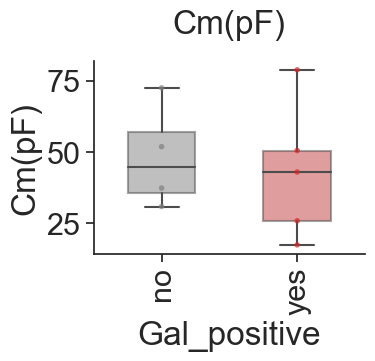

Firing_freq_(Hz)_I0 ('yes', 'no') 1.0
Gal_positive
no     2.565
yes    0.740
Name: Firing_freq_(Hz)_I0, dtype: float64


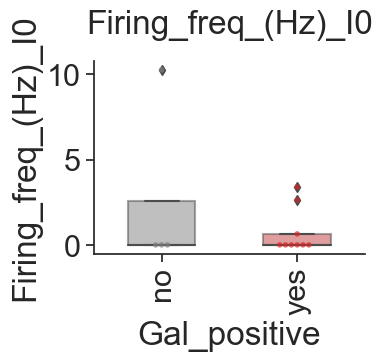

Instant_freq_(Hz) ('yes', 'no') 1.0
Gal_positive
no     2.600000
yes    0.871111
Name: Instant_freq_(Hz), dtype: float64


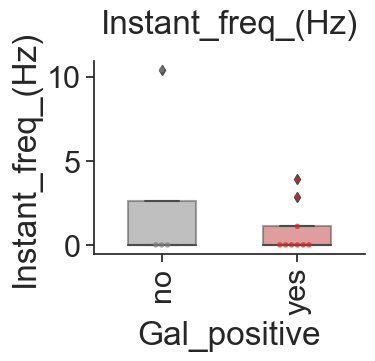

isi_(ms) ('yes', 'no') 0.5
Gal_positive
no      97.420000
yes    740.333333
Name: isi_(ms), dtype: float64


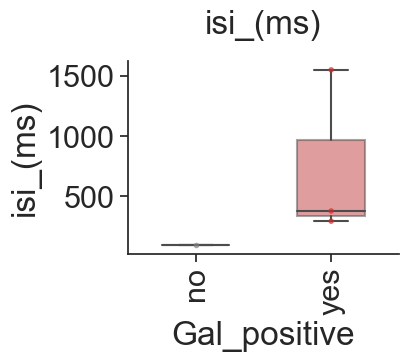

CaT ('yes', 'no') 0.5842375964997912
Gal_positive
no     8.507500
yes    1.842857
Name: CaT, dtype: float64


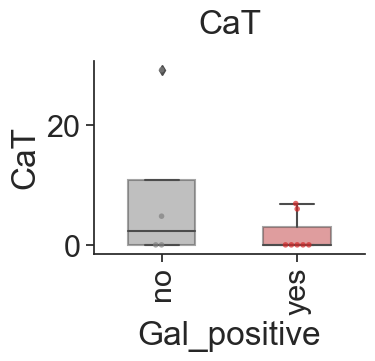

Ih_at_-120mV ('yes', 'no') 0.5376384478605154
Gal_positive
no     3.28750
yes    4.52875
Name: Ih_at_-120mV, dtype: float64


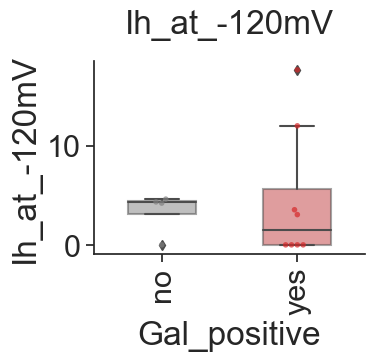

AP_ampl ('yes', 'no') 0.5
Gal_positive
no     98.400000
yes    70.266667
Name: AP_ampl, dtype: float64


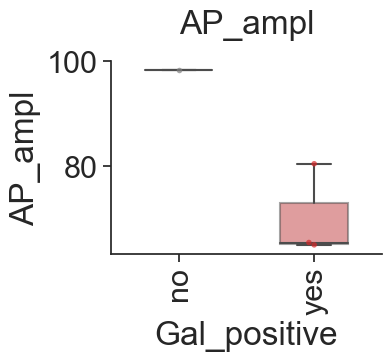

AP_halfwidth ('yes', 'no') 0.5
Gal_positive
no     1.710000
yes    3.613333
Name: AP_halfwidth, dtype: float64


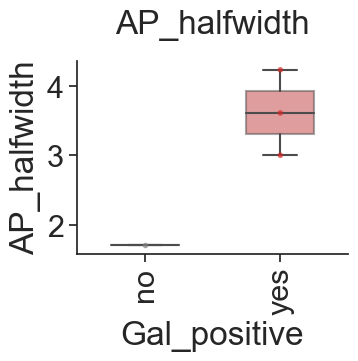

AP_time_to_peak ('yes', 'no') 0.5
Gal_positive
no     0.620000
yes    2.026667
Name: AP_time_to_peak, dtype: float64


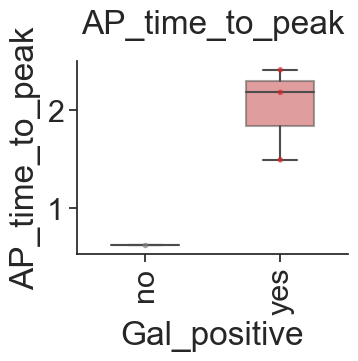

area(mV_ms) ('yes', 'no') 0.5
Gal_positive
no     132.000000
yes    240.766667
Name: area(mV_ms), dtype: float64


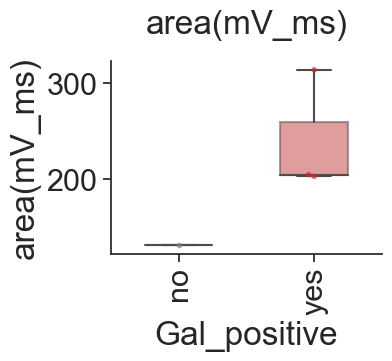

rheobase_at_-60mV_(pA) ('yes', 'no') 0.9309874465595671
Gal_positive
no     39.5
yes    20.5
Name: rheobase_at_-60mV_(pA), dtype: float64


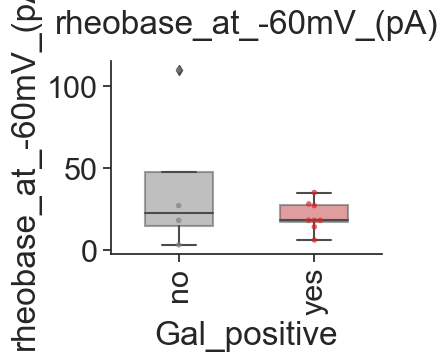

AHP_(mV) ('yes', 'no') 0.5
Gal_positive
no    -53.700000
yes   -44.816667
Name: AHP_(mV), dtype: float64


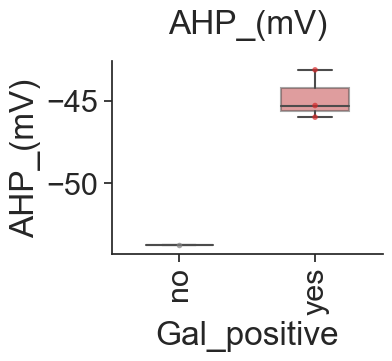

Vm ('yes', 'no') 0.005594405594405594
Gal_positive
no    -54.158175
yes   -39.845540
Name: Vm, dtype: float64


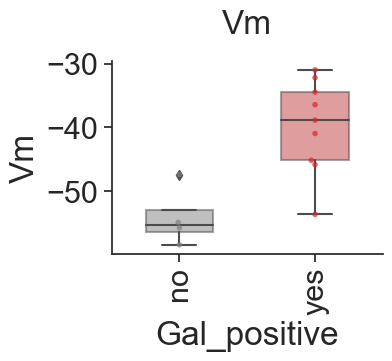

Input_Resistance ('yes', 'no') 0.6828282828282828
Gal_positive
no     672.011750
yes    680.159409
Name: Input_Resistance, dtype: float64


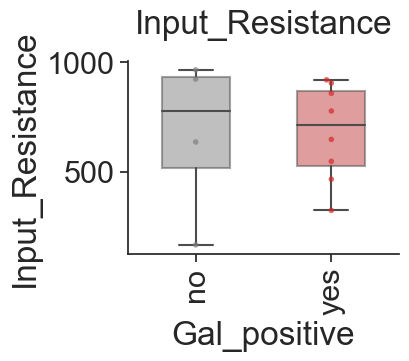

sPSC_frequency ('yes', 'no') 0.6041958041958042
Gal_positive
no     1.634487
yes    2.964686
Name: sPSC_frequency, dtype: float64


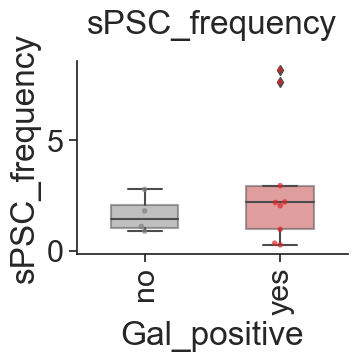

sPSC_Amplitude(pA) ('yes', 'no') 0.5034965034965035
Gal_positive
no     11.982500
yes    10.981111
Name: sPSC_Amplitude(pA), dtype: float64


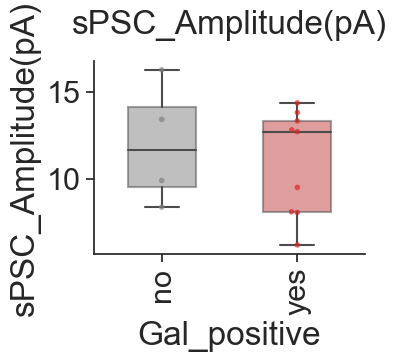

sPSCs_Rise time ('yes', 'no') 0.8139237277305011
Gal_positive
no     1.275000
yes    1.188889
Name: sPSCs_Rise time, dtype: float64


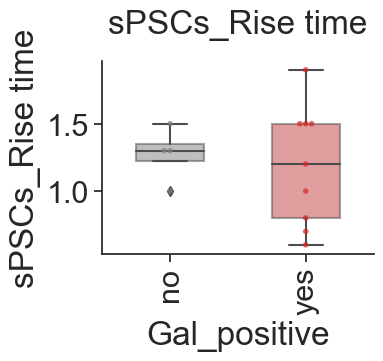

sPSCs (decay) ('yes', 'no') 0.1986013986013986
Gal_positive
no      8.942500
yes    12.294444
Name: sPSCs (decay), dtype: float64


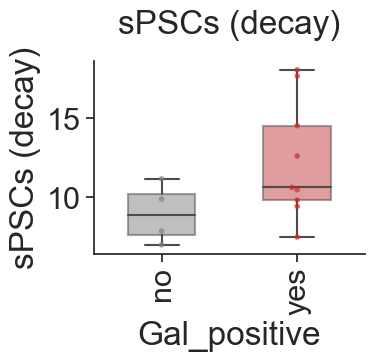

In [77]:
preprocess_plot(ephys[(ephys.Gal_positive.isin(['no', 'yes'])) & (ephys.Behaviour_6hFD.isin(['Agg-', 'Agg+']))], 
                'Gal_positive', 'gal', palette=['Gray', 'Tab:red'], order = ['no', 'yes'], plotting= True)


In [12]:
preprocess_plot(no_gal,'gal_minus')

TypeError: preprocess_plot() missing 1 required positional argument: 'name'

Cm(pF) 0.7323693239926063


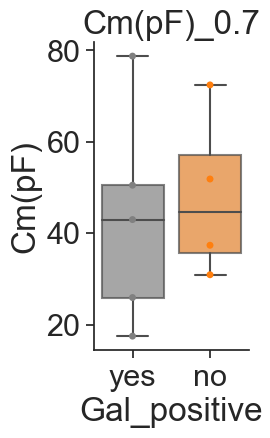

Firing_freq_(Hz)_I0 0.6407646405225094


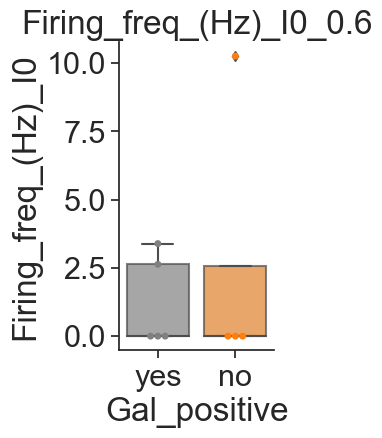

Instant_freq_(Hz) 0.6729139443059836


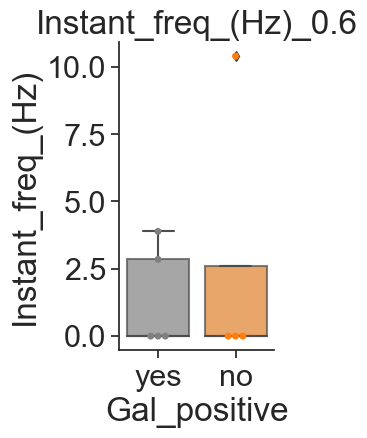

isi_(ms) 0.264690461240659


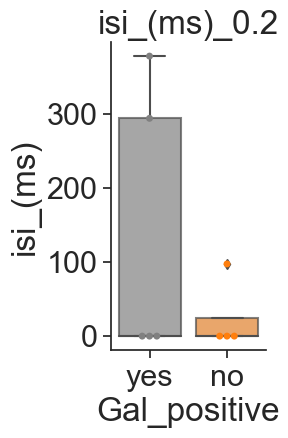

CaT 0.3112911367063223


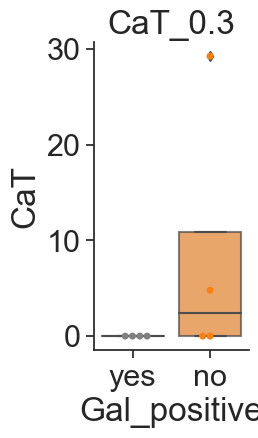

Ih_at_-120mV 0.8027274535869496


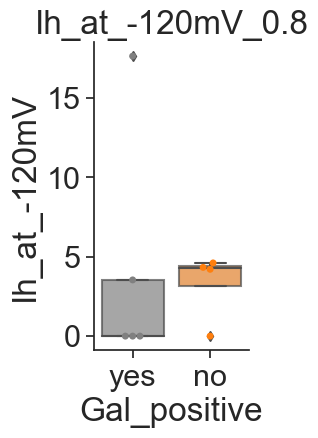

AP_ampl 0.8859255231987084


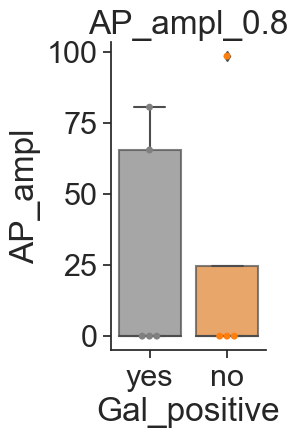

AP_halfwidth 0.32548590700011526


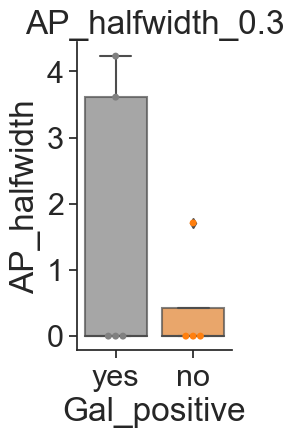

AP_time_to_peak 0.2899382771639767


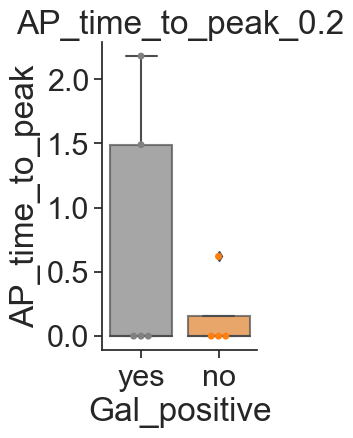

area(mV_ms) 0.37498685458791303


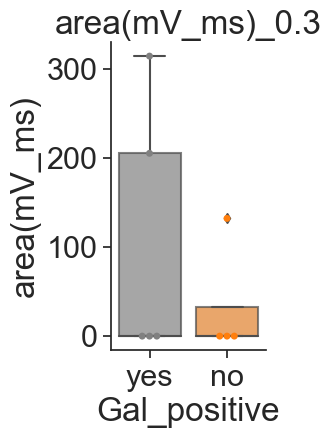

rheobase_at_-60mV_(pA) 0.4161053280322605


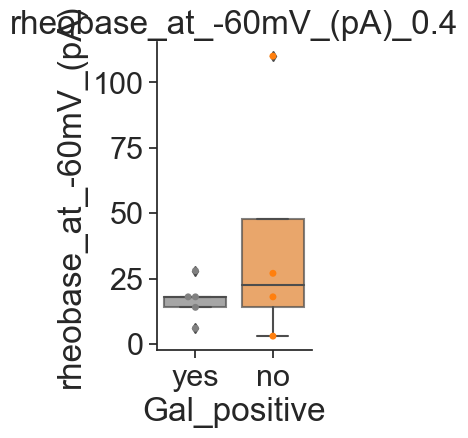

AHP_(mV) 0.80731274924489


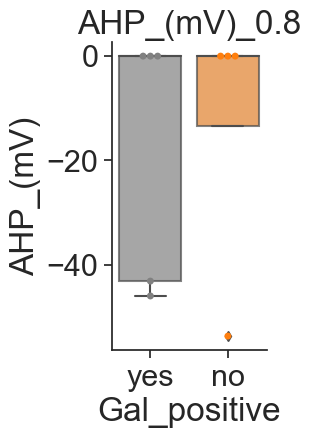

Vm 0.029015379302906888


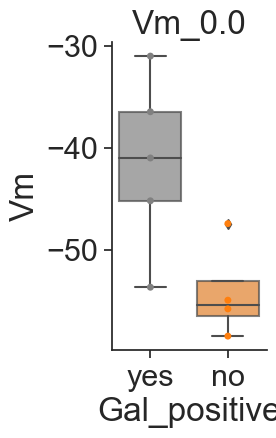

Input_Resistance 0.5478892229399508


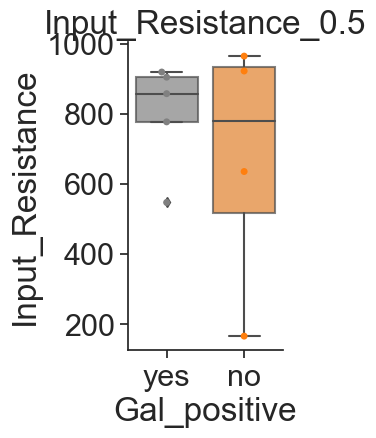

sPSC_frequency 0.2622481192712615


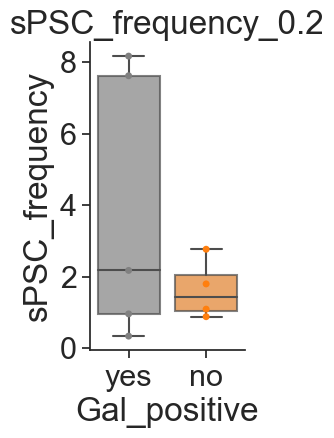

sPSC_Amplitude(pA) 0.8336416545013177


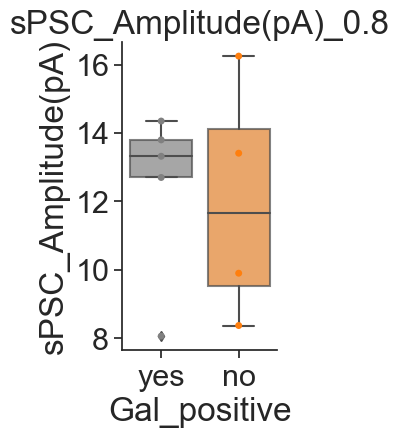

sPSCs_Rise time 0.1506195618276333


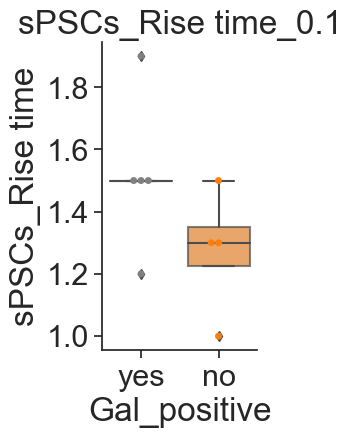

sPSCs (decay) 0.1946103198988765


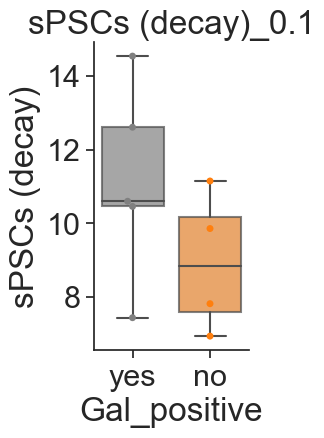

AC-I0 nan
AC_-60 nan


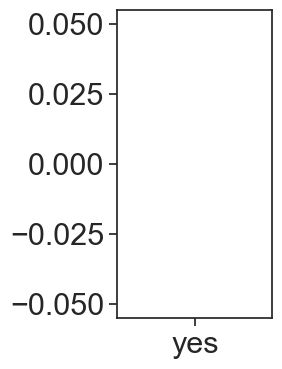

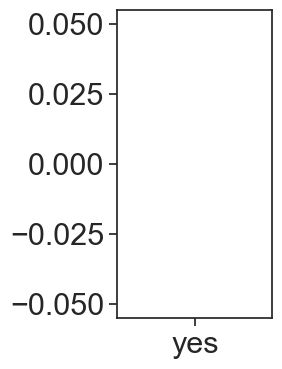

In [13]:
gals = pd.concat([gal,no_gal], axis = 0)
gals = gals[gals.Behaviour_6hFD.isin(['Agg+', 'Agg-'])]

ls = ['Cm(pF)', 'Firing_freq_(Hz)_I0','Instant_freq_(Hz)', 'isi_(ms)',  'CaT',  'Ih_at_-120mV', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak','area(mV_ms)', 'rheobase_at_-60mV_(pA)', 'AHP_(mV)', 'Vm',
   'Input_Resistance', 'sPSC_frequency', 'sPSC_Amplitude(pA)','sPSCs_Rise time', 'sPSCs (decay)', 'AC-I0', 'AC_-60']

for column in ls:
    try:
        _, p = stats.ttest_ind(gals[(gals.Gal_positive == 'yes')][column].dropna(),
                                    gals[(gals.Gal_positive == 'no')][column].dropna(),
                                    equal_var = False)
        print(column , p)


        gals[column] = pd.to_numeric(gals[column])
        fig,ax = plt.subplots(figsize = (2,4))
        sns.swarmplot(x='Gal_positive', y =column, data= gals, palette = ['gray', 'Tab:orange'])
        sns.boxplot(x='Gal_positive', y =column, data= gals, palette = ['gray', 'Tab:orange'], boxprops=dict(alpha=0.7))
        sns.despine()
        plt.title(column + '_' + str(p)[:3])
        plt.savefig(f'output_figures/gal_nogal_{column}.png',dpi = 300, bbox_inches = 'tight')
        plt.show()
    except Exception:
        continue

In [17]:
trial = ephys[ephys.Behaviour_6hFD.isin(['Pre', 'Agg-', 'Agg+'])]
trial = trial.rename(columns={'Ih_at_-120mV': 'ih_current', 
                              'Firing_freq_(Hz)_I0': 'firing_freq', 
                              'sPSC_Amplitude(pA)': 'sPSC_Amplitude'})
model = smf.ols('Input_Resistance ~  ih_current  ', data=trial).fit()
#model.summary()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
ih_current,1.072356e+06,1.0,21.100988,0.000007
Residual,1.240013e+07,244.0,NaN,NaN


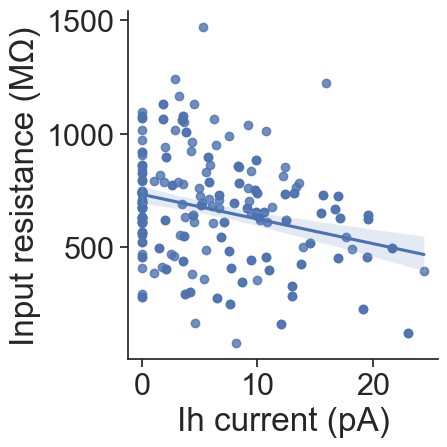

In [19]:
sns.lmplot(x = 'ih_current', y = 'Input_Resistance', data = trial, palette = ['darkgray', '#F97306', 'blue'])
plt.xlabel('Ih current (pA)')
plt.ylabel('Input resistance (MΩ)')
plt.savefig(f'output_figures/ih_input_resistance.png',dpi = 300, bbox_inches = 'tight')
          


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


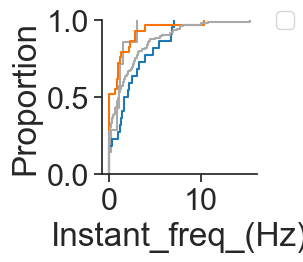

In [39]:
l = 'Instant_freq_(Hz)'
max = ephys[l].max()
cs = ['darkgray', '#F97306', 'Tab:blue']
conds = ['Pre', 'Agg+', 'Agg-']
fig, ax = plt.subplots(figsize=(2, 2))
sns.ecdfplot(data=ephys[ephys.Behaviour_6hFD.isin(conds)], x=l, hue="Behaviour_6hFD", palette = cs, ax = ax)
sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 1), fontsize = 16)

plt.savefig(f'output_figures/ECDF_{l}.png',dpi = 300, bbox_inches = 'tight')
plt.show()

    

## silent prop

I_zero          phasic  silent  tonic  All
Behaviour_6hFD                            
Pre                 19      28     58  105
Agg+                 6      15      8   29
Agg-                 4       4     14   22
npy_10               2       1     12   15
ZD7288               0       8      1    9
All                 31      56     93  180
0.0002477230976052094


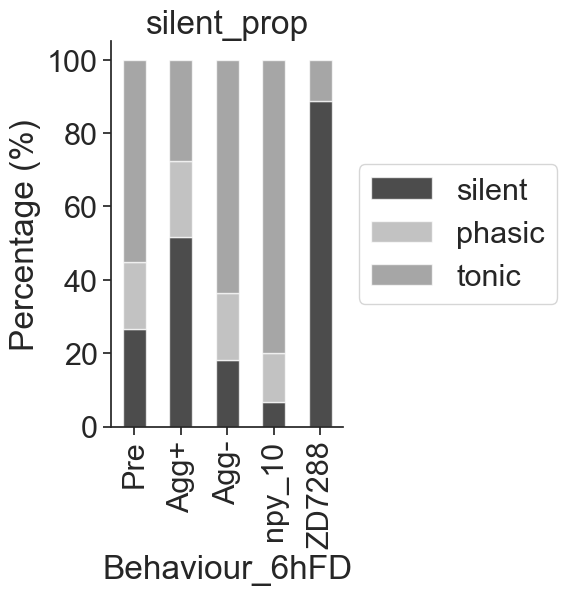

In [27]:
## silent proportion
cols = ['silent', 'phasic', 'tonic']
cat = ['Pre', 'Agg+', 'Agg-', 'npy_antag', 'npy_10', 'ZD7288']
silent_prop = proportion(ephys[ephys.Behaviour_6hFD.isin(cat)], 'Behaviour_6hFD', 'I_zero', cols)
silent_prop['Behaviour_6hFD'] = pd.Categorical(silent_prop['Behaviour_6hFD'], cat)
silent_prop = silent_prop.sort_values(by = ['Behaviour_6hFD'])
prop_plot(silent_prop, 'Behaviour_6hFD')
plt.xticks(rotation = 90)
plt.title('silent_prop')
plt.savefig('output_figures/silent_prop.png',dpi = 300, bbox_inches = 'tight')

In [28]:
cols = ['silent', 'tonic']
silent_prop = proportion(gals, 'Gal_positive', 'I_zero', cols)
silent_prop['Gal_positive'] = pd.Categorical(silent_prop['Gal_positive'], ['yes', 'no'])
silent_prop = silent_prop.sort_values(by = ['Gal_positive'])
prop_plot(silent_prop, 'Gal_positive')
plt.title('galanin_silent_prop')
plt.savefig('output_figures/galanin_silent_prop.png',dpi = 300, bbox_inches = 'tight')

NameError: name 'gals' is not defined

## adaptive prop

Adaptive        ?  no  yes  All
Behaviour_6hFD                 
Pre             1  15   27   43
Agg+            1  12   16   29
Agg-            0  18    3   21
All             2  45   46   93
0.0035491449670240205


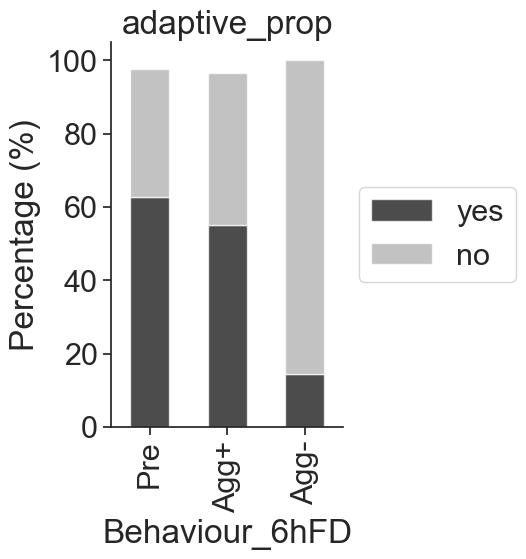

In [29]:
## adaptive proportion
cols = ['yes', 'no']
cat = ['Pre', 'Agg+', 'Agg-']
ad_prop = proportion(ephys[ephys.Behaviour_6hFD.isin(cat)], 'Behaviour_6hFD', 'Adaptive', cols)
ad_prop['Behaviour_6hFD'] = pd.Categorical(ad_prop['Behaviour_6hFD'], cat)
ad_prop = ad_prop.sort_values(by = ['Behaviour_6hFD'])

prop_plot(ad_prop, 'Behaviour_6hFD')
plt.xticks(rotation = 90)
plt.title('adaptive_prop')
plt.savefig('output_figures/adaptive_prop.png',dpi = 300, bbox_inches = 'tight')

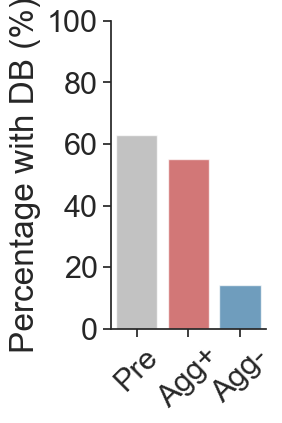

In [38]:
plt.subplots(figsize = (2,4))
sns.barplot(x = 'Behaviour_6hFD', y = 'yes',data = ad_prop, palette= ['darkgray', 'Tab:red', 'Tab:blue'], alpha = 0.7)
plt.xticks(rotation = 45)
plt.ylim([0,100])
plt.ylabel('Percentage with DB (%)')
plt.xlabel('')
sns.despine()
plt.savefig('output_figures/adaptive_prop.png',dpi = 300, bbox_inches = 'tight')

In [77]:
cols = ['yes', 'no']
ad_prop = proportion(gals, 'Gal_positive', 'Adaptive', cols)
ad_prop['Gal_positive'] = pd.Categorical(ad_prop['Gal_positive'], ['yes', 'no'])
ad_prop = ad_prop.sort_values(by = ['Gal_positive'])
prop_plot(ad_prop, 'Gal_positive')
plt.title('galanin_adaptive_prop')
plt.savefig('output_figures/galanin_adaptive_prop.png',dpi = 300, bbox_inches = 'tight')

NameError: name 'gals' is not defined

## calcium T prop

cat_categ         no  no   yes  yes   All
Behaviour_6hFD                           
Agg+              20    0    8     0   28
Agg-               9    1   11     1   22
Pre               51    0   31     0   82
ZD7288             6    0    3     0    9
ZD7288_20          2    0    1     0    3
agrp_100           7    0    0     0    7
agrp_100_paired    6    0    1     0    7
npy_10             3    1    0     0    4
npy_100            4    0    0     0    4
npy_antag         14    0    1     0   15
All              122    2   56     1  181
0.004202880379034892


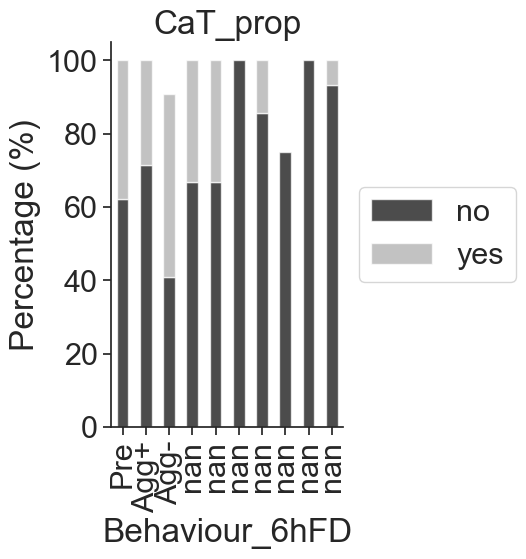

In [114]:
## calcium T proportion
cols = ['no', 'yes']
ca_prop = proportion(ephys, 'Behaviour_6hFD', 'cat_categ', cols)
ca_prop['Behaviour_6hFD'] = pd.Categorical(ca_prop['Behaviour_6hFD'],cat)
ca_prop = ca_prop.sort_values(by = ['Behaviour_6hFD'])
prop_plot(ca_prop, 'Behaviour_6hFD')
plt.xticks(rotation = 90)

plt.title('CaT_prop')
plt.savefig('output_figures/CaT_prop.png',dpi = 300, bbox_inches = 'tight')

In [79]:
cols = ['yes', 'no']
ca_prop = proportion(gals, 'Gal_positive', 'cat_categ', cols)
ca_prop['Gal_positive'] = pd.Categorical(ca_prop['Gal_positive'], ['yes', 'no'])
ca_prop = ca_prop.sort_values(by = ['Gal_positive'])
prop_plot(ca_prop, 'Gal_positive')

plt.title('galanin_CaT_prop')
plt.savefig('output_figures/galanin_CaT_prop.png',dpi = 300, bbox_inches = 'tight')

NameError: name 'gals' is not defined

## IH prop

IH               no  yes  All
Behaviour_6hFD               
Agg+             11   17   28
Agg-              1   21   22
Pre              24   58   82
ZD7288            9    0    9
ZD7288_20         3    0    3
agrp_100          5    2    7
agrp_100_paired   1    6    7
npy_10            3    1    4
npy_100           4    0    4
npy_100_paired    2    1    3
npy_10_paired     0    5    5
npy_antag         3   12   15
All              66  123  189
1.2495740282987222e-07


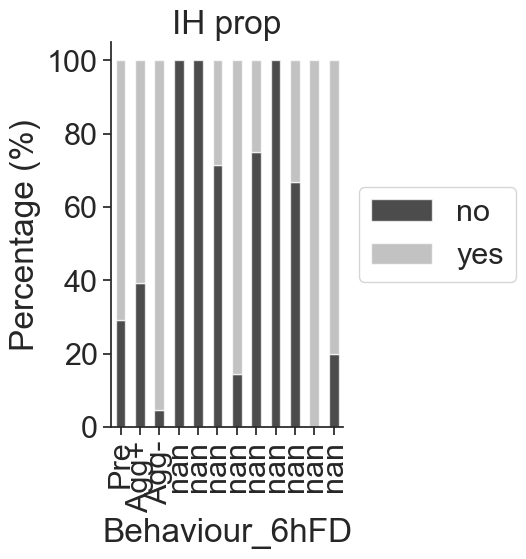

In [116]:
ephys.loc[(ephys['Ih_at_-120mV'] == 0), 'IH']  = 'no'
ephys.loc[(ephys['Ih_at_-120mV'] >0 ), 'IH']  = 'yes'
cols = ['no', 'yes']

ca_prop = proportion(ephys, 'Behaviour_6hFD', 'IH', cols)
ca_prop['Behaviour_6hFD'] = pd.Categorical(ca_prop['Behaviour_6hFD'], cat)
ca_prop = ca_prop.sort_values(by = ['Behaviour_6hFD'])
prop_plot(ca_prop, 'Behaviour_6hFD')

plt.title('IH prop')
plt.xticks(rotation = 90)
plt.savefig('output_figures/IH_prop.png',dpi = 300, bbox_inches = 'tight')

IH                   no  yes  All
I_zero_reclassified              
phasic                7   25   32
silent               31   39   70
tonic                26   59   85
All                  64  123  187
0.05461411697391892


Text(0.5, 0, '')

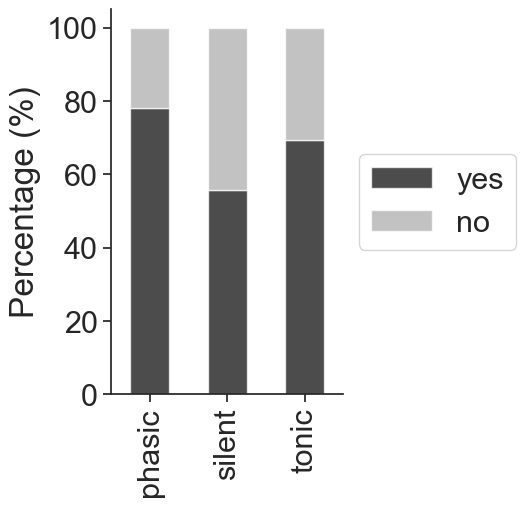

In [117]:
cols = ['yes', 'no']
ih_prop =  proportion(ephys, 'I_zero_reclassified', 'IH', cols)
# ca_prop = ca_prop.sort_values(by = ['Behaviour_6hFD'])
prop_plot(ih_prop, 'I_zero_reclassified')
plt.xticks(rotation = 90)
plt.xlabel('')

# ramp analysis

In [ ]:
df = pd.read_csv('ramps_all.csv')
ephys = pd.read_csv('sampled_ephys_data.csv')
ephys.rename(columns = {'Instant_freq_(Hz)_1/ISI':'Instant_freq_(Hz)', 
                        'experiment_day':'filename'}, inplace =True)

df.rename(columns = {'I_Injected(pA)': 'Injected'}, inplace = True)
df = pd.merge(df, ephys, on = 'filename')

df['Injected'] = pd.Categorical(df['Injected'], df['Injected'].unique()[:-2]).as_ordered()

start = df['Ramp_start'][0]
num_spike = df.groupby(by = ['filename', 'Injected']).size().reset_index(name ='num_spike')
df = df.groupby(['filename', 'Injected'], dropna = False).first().reset_index().drop_duplicates()

df.loc[df['Event start '] == 0,'Event start '] = 2080
df['latency'] = df['Event start ']- start
df['num_spike'] = num_spike.num_spike
df =  pd.merge(df, ephys, on = ['filename', 'Behaviour_6hFD'])



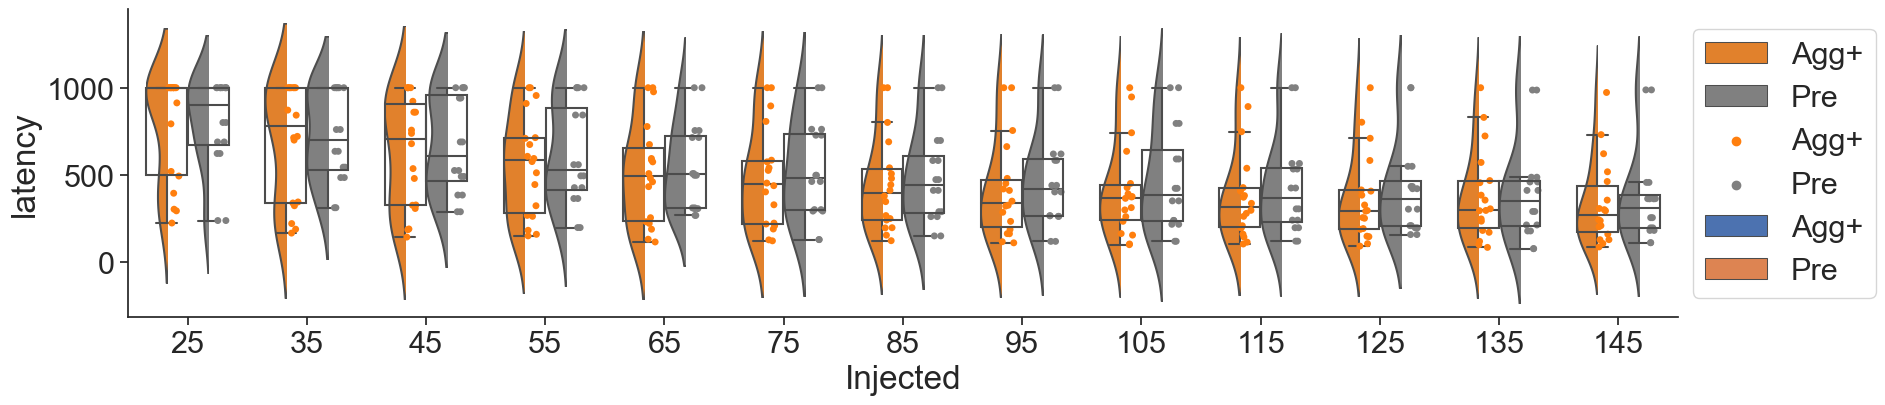

In [ ]:
prop = 'latency'

fig = plt.subplots(figsize = [20,4])

palette = ['Tab:orange', 'gray']
ax = sns.violinplot(x ='Injected', y = prop, hue = 'Behaviour_6hFD', 
                    dodge = True, data = df,
                    palette=palette,width = 0.7,
                    scale="width", inner=None)

# ax = sns.lmplot(x ='Injected', y = prop, hue = 'Behaviour_6hFD', data = df)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

old_len_collections = len(ax.collections)
sns.stripplot(x  = 'Injected', y = prop, hue = 'Behaviour_6hFD',
               dodge = True, data = df, palette=palette, ax=ax)

sns.boxplot(x  = 'Injected', y = prop, hue = 'Behaviour_6hFD',
                data = df, saturation=1, showfliers=False,
            width=0.7, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)


for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([.08, 0]))
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
model = smf.ols('latency ~ C(Injected) * C(Behaviour_6hFD)', data=df).fit()
#model.summary()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Injected),7.381683e+06,12.0,8.054835,1.237526e-13
C(Behaviour_6hFD),1.470714e+05,1.0,1.925798,1.659617e-01
C(Injected):C(Behaviour_6hFD),1.909296e+04,12.0,0.020834,1.000000e+00
Residual,3.176953e+07,416.0,NaN,NaN


In [ ]:
df['combination'] = df.Injected.astype(str) + " / " + df.Behaviour_6hFD
m_comp = pairwise_tukeyhsd(endog=df['latency'], groups=df['combination'], alpha=0.05)
m_comp._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
105 / Agg+,105 / no_FD,53.6741,1.0,-402.1284,509.4766,False
105 / Agg+,115 / Agg+,-24.5592,1.0,-389.2012,340.0828,False
105 / Agg+,115 / no_FD,10.2366,1.0,-445.5659,466.0391,False
105 / Agg+,125 / Agg+,-40.0064,1.0,-404.6483,324.6356,False
105 / Agg+,125 / no_FD,-4.3258,1.0,-460.1283,451.4766,False
105 / Agg+,135 / Agg+,-25.7058,1.0,-390.3478,338.9361,False
105 / Agg+,135 / no_FD,-25.2135,1.0,-481.016,430.5889,False
105 / Agg+,145 / Agg+,-68.4944,1.0,-433.1364,296.1476,False
105 / Agg+,145 / no_FD,-48.6384,1.0,-504.4409,407.1641,False
105 / Agg+,25 / Agg+,359.0997,0.0598,-5.5423,723.7417,False


# estrous cycle influence

I_zero             phasic  silent  tonic  All
estrous_stage                                
?                       1       1      2    4
D                       5       7     16   28
E                       2       3      3    8
M                       3       7     14   24
P                       6       6     12   24
VS to be stained        0       0      1    1
no VS                   1       2      9   12
not taken               1       2      1    4
All                    19      28     58  105
0.9417552913501139
Empty DataFrame
Columns: []
Index: []


ValueError: No data; `observed` has size 0.

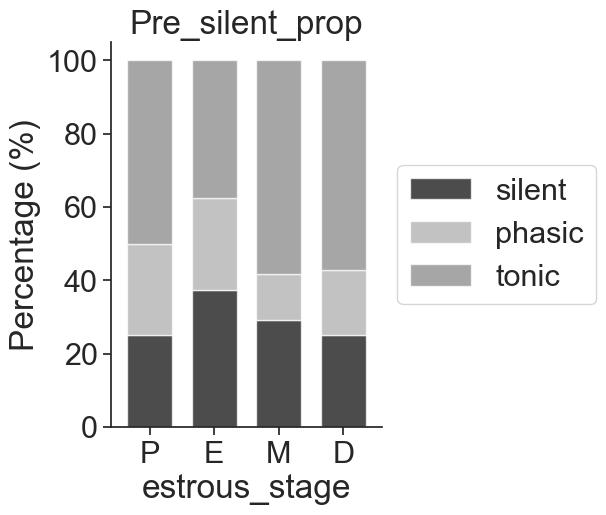

In [32]:
# silent proportion
ephys = pd.read_csv('sampled_ephys_data.csv')

ephys = ephys[ephys.I_zero.isin(['silent', 'phasic', 'tonic'])]
ephys.loc[(ephys['estrous_stage'] == 'P to E'), 'estrous_stage']  = 'P'
ephys.loc[(ephys['estrous_stage'] == 'D to P'), 'estrous_stage']  = 'D'
cols = ['silent', 'phasic', 'tonic']
# ephys.loc[ephys.Behaviour_6hFD.isin(['Agg+']),'Behaviour_6hFD'] = 'Post'

for state in ['Pre', 'Post']:
    state_df = ephys[ephys.Behaviour_6hFD == state]
    silent_prop = proportion(state_df, 'estrous_stage', 'I_zero', cols)
    silent_prop['estrous_stage'] = pd.Categorical(silent_prop['estrous_stage'], ['P', 'E', 'M', 'D'])
    silent_prop = silent_prop.sort_values(by = ['estrous_stage'])
    silent_prop = silent_prop[silent_prop.estrous_stage.isin(['P', 'E', 'M', 'D'])]
    


    silent_prop.plot(x = 'estrous_stage', 
            kind = 'bar', 
            stacked = True,  
            mark_right = False,
            color = ['black', 'darkgray','gray'],
            figsize = (3.5,5), alpha = 0.7, width = 0.7)
 
        
    plt.xticks(rotation = 0)
    ax = plt.gca()
    plt.ylabel('Percentage (%)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title(f'{state}_silent_prop')
    plt.savefig(f'output_figures/{state}_silent_prop.png',dpi = 300, bbox_inches = 'tight')

-0.5709724581245322 0.42902754187546777


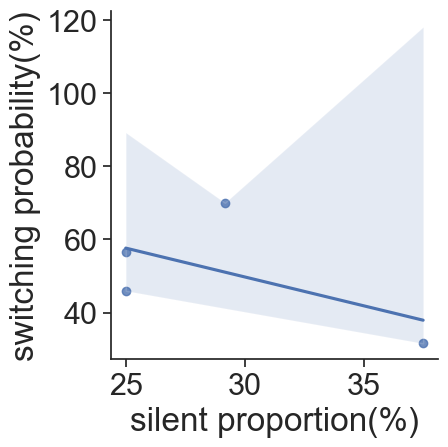

In [33]:
import scipy as sp
estrous_df = pd.read_csv('../NPS_behaviour_analysis/generated_datasets/estrous_data.csv')
estrous_df.rename(columns = {'Unnamed: 0':'estrous_stage', '0':'switching probability'}, inplace = True)
corr = pd.merge(silent_prop, estrous_df, on = 'estrous_stage')

r, p = sp.stats.pearsonr(corr['switching probability'], corr['silent'])
print(r, p)
sns.lmplot(x = 'silent', y = 'switching probability', data = corr)
plt.xlabel('silent proportion(%)')
plt.ylabel('switching probability(%)')
plt.savefig('output_figures/silent_switching_corr.png', dpi = 300, bbox_inches = 'tight')

Ih_at_-120mV 0.009539512286860998


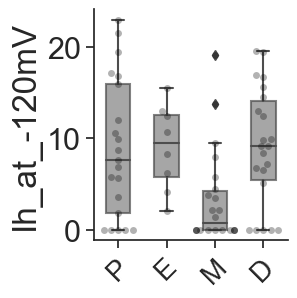

In [39]:
# IH current
ls = ['Cm(pF)', 'Firing_freq_(Hz)_I0','Instant_freq_(Hz)', 'isi_(ms)',  'CaT',  'Ih_at_-120mV', 'AP_ampl', 'AP_halfwidth', 'AP_time_to_peak','area(mV_ms)', 'rheobase_at_-60mV_(pA)', 'AHP_(mV)', 'Vm',
       'Input_Resistance', 'sPSC_frequency', 'sPSC_Amplitude(pA)','sPSCs_Rise time', 'sPSCs (decay)', 'AC-I0', 'AC_-60']

# ls = ['Ih_at_-120mV']

for state in ['Pre']:
    for column in ls:
        # state_df = ephys[ephys.Behaviour_6hFD == state]
        state_df = ephys.copy()
        state_df['estrous_stage'] = pd.Categorical(state_df['estrous_stage'], ['P', 'E', 'M', 'D'])
        state_df = state_df[state_df.Behaviour_6hFD == state]
        
        try:

            _, p = stats.f_oneway(state_df[column][state_df['estrous_stage'] == 'P'].dropna(),
                                    state_df[column][state_df['estrous_stage'] == 'E'].dropna(),
                                    state_df[column][state_df['estrous_stage'] == 'M'].dropna(),
                                    state_df[column][state_df['estrous_stage'] == 'D'].dropna())
            

            
            if p < 0.05:
                print(column , p)

                fig,ax = plt.subplots(figsize = (2.5,3))
                sns.swarmplot(x='estrous_stage', y =column, data= state_df, alpha = 0.3, color = 'black')
                sns.boxplot(x='estrous_stage', y =column, data= state_df, boxprops=dict(alpha=0.7), width = 0.5, palette = ['gray'])
                sns.despine()
                plt.xticks(rotation = 45, fontsize = 20)
                # plt.ylabel('Ih current (pA)', fontsize = 25)
                plt.xlabel('')
            
                # plt.title(f'{state}_{column}', pad = 20)
                plt.savefig(f'output_figures/{state}_{column}.png',dpi = 300, bbox_inches = 'tight')
            
            plt.show()
        except Exception:
            continue

cat_categ          no  yes  All
estrous_stage                  
?                   1    3    4
D                  11   11   22
E                   4    4    8
M                  17    5   22
P                  15    6   21
VS to be stained    1    0    1
not taken           2    2    4
All                51   31   82
0.23806780090893834
cat_categ estrous_stage         no        yes
4                     P  71.428571  28.571429
2                     E  50.000000  50.000000
3                     M  77.272727  22.727273
1                     D  50.000000  50.000000


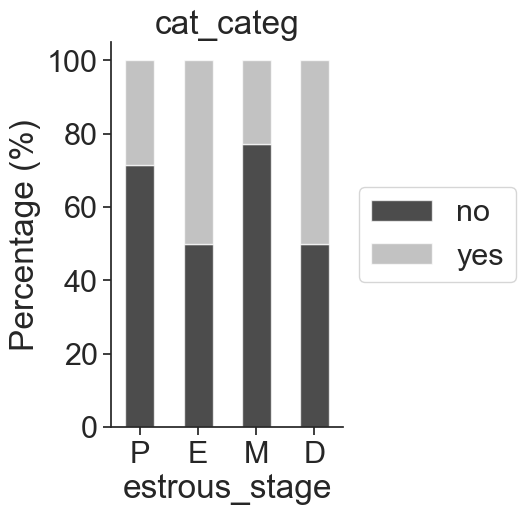

0.9146286513211039 0.08537134867889606


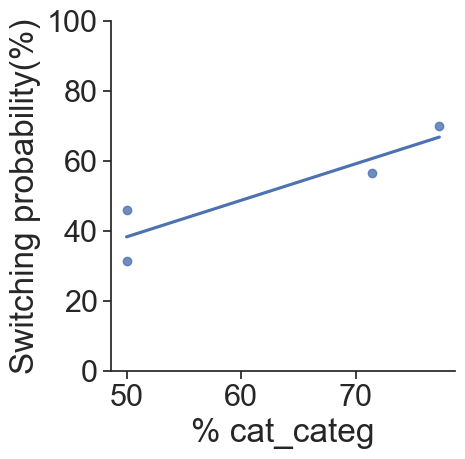

IH                 no  yes  All
estrous_stage                  
?                   0    4    4
D                   5   17   22
E                   0    8    8
M                  11   11   22
P                   5   16   21
VS to be stained    1    0    1
not taken           2    2    4
All                24   58   82
0.0352565677238345
IH estrous_stage         no         yes
4              P  23.809524   76.190476
2              E   0.000000  100.000000
3              M  50.000000   50.000000
1              D  22.727273   77.272727


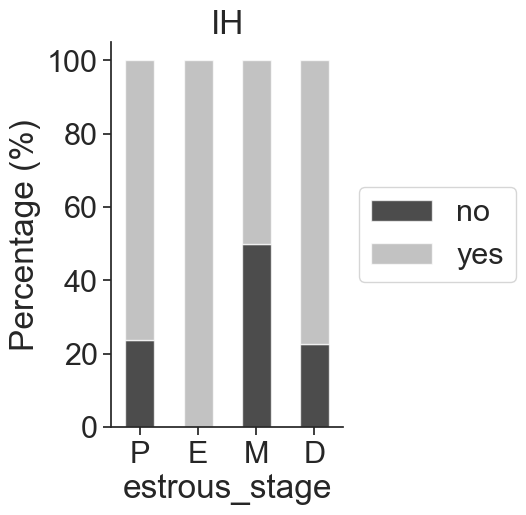

0.9665783850876507 0.033421614912349296


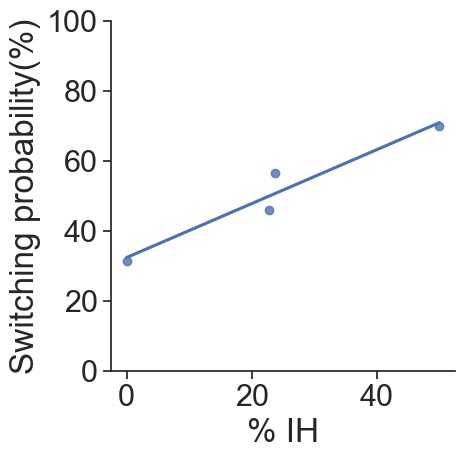

Adaptive           ?  no  yes  All
estrous_stage                     
?                  0   0    1    1
D                  0   4    6   10
E                  0   1    1    2
M                  0   7   11   18
P                  1   3    7   11
VS to be stained   0   0    1    1
All                1  15   27   43
0.9166519983189608
Adaptive estrous_stage         no        yes
4                    P  27.272727  63.636364
2                    E  50.000000  50.000000
3                    M  38.888889  61.111111
1                    D  40.000000  60.000000


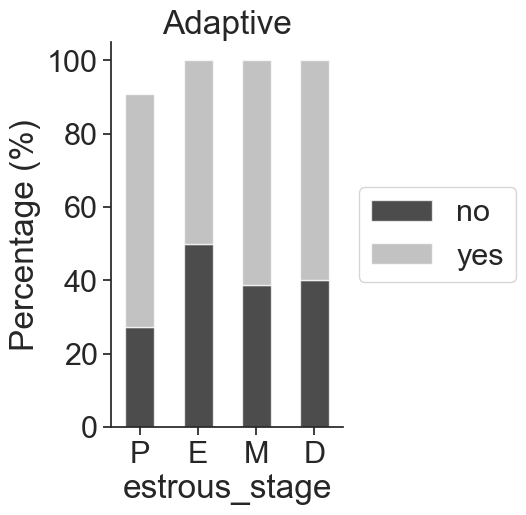

-0.6320737885969195 0.36792621140308046


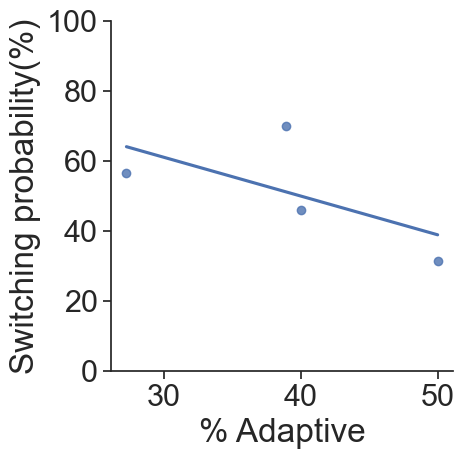

In [47]:
import scipy as sp
cols = ['no', 'yes']
ephys.loc[(ephys['Ih_at_-120mV'] == 0), 'IH']  = 'no'
ephys.loc[(ephys['Ih_at_-120mV'] >0 ), 'IH']  = 'yes'


estrous_df = pd.read_csv('../NPS_behaviour_analysis/generated_datasets/estrous_data.csv')
estrous_df.rename(columns = {'Unnamed: 0':'estrous_stage', '0':'switching probability'}, inplace = True)
ephys_pre = ephys[ephys.Behaviour_6hFD == 'Pre']

for column in ['cat_categ', 'IH', 'Adaptive']:
    esprop = proportion(ephys_pre, 'estrous_stage', column, cols)
    esprop['estrous_stage'] = pd.Categorical(esprop['estrous_stage'], ['P', 'E', 'M', 'D'])
    esprop = esprop.sort_values(by = ['estrous_stage']).dropna()
    prop_plot(esprop, 'estrous_stage')
    print(esprop)
    plt.title(column)
    plt.show()

    corr = pd.merge(esprop, estrous_df, on = 'estrous_stage')
    r, p = sp.stats.pearsonr(corr['switching probability'], corr['no'])
    print(r, p)

    sns.lmplot(x = 'no', y = 'switching probability', data = corr, ci = None)
    plt.ylim([0, 100])
    plt.xlabel(f'% {column}')
    plt.ylabel('Switching probability(%)')
    plt.savefig(f'output_figures/{column}_switching_corr.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

IH                 no  yes  All
estrous_stage                  
?                   0    4    4
D                   5   17   22
E                   0    8    8
M                  11   11   22
P                   5   16   21
VS to be stained    1    0    1
not taken           2    2    4
All                24   58   82
0.0352565677238345
Adaptive           ?  no  yes  All
estrous_stage                     
?                  0   0    1    1
D                  0   4    6   10
E                  0   1    1    2
M                  0   7   11   18
P                  1   3    7   11
VS to be stained   0   0    1    1
All                1  15   27   43
0.9166519983189608
-0.284545136651464 0.715454863348536


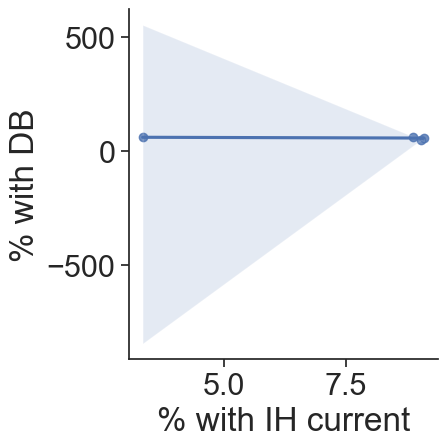

In [18]:

cols = ['no', 'yes']
estrous_stages = ['P', 'E', 'M', 'D']
ih_prop = proportion(ephys_pre, 'estrous_stage', 'IH', cols)
ih_est_mean = ephys_pre.groupby('estrous_stage')['Ih_at_-120mV'].mean().reset_index()
adaptive_prop = proportion(ephys_pre, 'estrous_stage', 'Adaptive', cols)
merged_df = pd.merge(ih_est_mean, adaptive_prop, on = 'estrous_stage')
merged_df = merged_df[merged_df.estrous_stage.isin(estrous_stages)]


r, p = sp.stats.pearsonr(merged_df['Ih_at_-120mV'], merged_df['yes'])
print(r, p)

sns.lmplot(x = 'Ih_at_-120mV', y = 'yes', data = merged_df)
# plt.ylim([0, /100])
plt.xlabel('% with IH current')
plt.ylabel('% with DB')
plt.show()